# 184.702 TU ML WS 18 - KDD Cup 1998

## Dzenan Hamzic BSc, TU Wien

In [1]:
import warnings
warnings.filterwarnings('ignore')
#warnings.filterwarnings(action='once')

In [2]:
import time
from pydoc import help
from collections import Counter
from string import ascii_letters
#import pydotplus
from sklearn.tree import export_graphviz
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.base import TransformerMixin
import sklearn
from sklearn import preprocessing
from sklearn.preprocessing import Imputer
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from scipy.stats import chi2_contingency
from sklearn.model_selection import GridSearchCV
#from sklearn.preprocessing import SimpleImputer
#from sklearn import Imputer
from sklearn.svm import SVC

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0)

In [3]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
pd.set_option('display.expand_frame_repr', True)

In [4]:
print('The scikit-learn version is {}.'.format(sklearn.__version__))
print('The numpy version is {}.'.format(np.__version__))

The scikit-learn version is 0.20.0.
The numpy version is 1.15.2.


In [5]:

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier

#from imblearn import under_sampling, over_sampling
#from imblearn.over_sampling import SMOTE

#Import Library of Gaussian Naive Bayes model
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [6]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

## Helper methods

In [239]:
''' Run tests with default algorithm settings '''
def run_tests(test_size, setting, X_train, X_test, y_train, y_test, log = False):
    rstate = 1234
    # algorithms
    algo_names = ["OneR",
                 "RandomForest",
                 "DecisionTree",
                 "Naive Bayes",
                 "LogisticRegression",
                 "ExtraTreesClassifier",
                 "KNN",
                 "SVM"]
    algo_list = [DecisionTreeClassifier(random_state=rstate,max_depth=1),
                RandomForestClassifier(random_state=rstate),
                 DecisionTreeClassifier(random_state=rstate),
                GaussianNB(),
                LogisticRegression(random_state=rstate),
                ExtraTreesClassifier(random_state=rstate),
                KNeighborsClassifier(n_jobs=-1),
                SVC(random_state=rstate)]

    performanceDf = pd.DataFrame()
    for algo,name in zip(algo_list,algo_names):
        #if log: print(algo,setting)
        algo_instance = algo

        t0=time.time()
        if log: print(name,"...fit")
        algo.fit(X_train, y_train)
        fit_time = round(time.time()-t0, 3)

        ## And score it on your testing data.
        if log: print(name,"...score")
        score = algo.score(X_test, y_test)

        ## prediction quality measures
        t0=time.time()
        if log: print(name,"...predict")
        y_predict = algo.predict(X_test)
        pred_time = round(time.time()-t0, 3)

        if log: print(name,"...performance")
        Performance.get_cmatrix(y_test, y_predict, 1)
        pp = Performance.get_perf(y_test, y_predict)
        pp["Algorithm"] = name
        pp["Setting"] = setting
        pp["fit_time"] = fit_time
        pp["pred_time"] = pred_time
        pp["score"] = score
        pp["testSize"] = test_size
        pp["Xsize"] = str(X_train.shape)
        
        pd2 = pd.DataFrame(pp, index=[0])
        if log:
            print(name,"...concat")
            print(performanceDf.shape)
            print(pd2.shape)
        performanceDf = pd.concat([performanceDf ,pd2])

    c_names =["Algorithm","F1","recall","precision","score","accuracy","Xsize","fit_time","pred_time","testSize","Setting"]    
    performanceDf.sort_values(by=['F1'], ascending=False, inplace=True)
    return performanceDf[c_names]

In [8]:
#run_tests(testSize, "meanMedianBinn", X_train, X_test, y_train, y_test, log=True)

In [9]:
def merge_train_test(train,test):
    assert len(train) == len(test)
    assert train.shape == test.shape
    length = len(train)
    df_all = pd.concat([train,test], axis=0)
    return df_all

In [10]:
def split_train_test(df, size):
    # first
    train = df[:size]
    #last
    test = df[size:]
    assert len(train) == len(test)
    assert train.shape == test.shape
    return [train, test]

In [11]:
def no_empty_cells():
    global raw_data_test, raw_data_train
    drop_target()
    assert raw_data_train.isnull().values.any() == False
    assert raw_data_test.isnull().values.any() == False
    return True

In [12]:
def add_target():
    global raw_data_train, XY_train, target_var
    raw_data_train[target_var] = XY_train

In [13]:
def drop_target():
    global raw_data_test, raw_data_train
    if target_var in raw_data_train.columns:
        raw_data_train.drop(target_var, axis=1, inplace=True)

In [14]:
def shape():
    global raw_data_test, raw_data_train
    drop_target()
    print(raw_data_test.shape,raw_data_train.shape)
    assert raw_data_test.shape == raw_data_train.shape

In [15]:
def make_submission_file(y_predicted, controlNr):
    df = pd.DataFrame()
    df["CONTROLN"] = controlNr
    df["TARGET_B"] = y_predicted
    df.to_csv('solution-1.csv', index=False)

In [16]:
''' Exploratory Analysis ''' 
def expl(data):
    return print(data.shape), print(data.count()), print(data.columns)
           

In [17]:
''' Element counter ''' 
def count(dd):
    print(Counter(dd))

In [18]:
''' Remove highly correlated columns '''
def trimm_correlated(df_in, threshold):
    df_corr = df_in.corr(method='pearson', min_periods=2)
    df_not_correlated = ~(df_corr.mask(np.tril(np.ones([len(df_corr)]*2, dtype=bool))).abs() > threshold).any()
    un_corr_idx = df_not_correlated.loc[df_not_correlated[df_not_correlated.index] == True].index
    df_out = df_in[un_corr_idx]
    # return uncorrelated columns
    return un_corr_idx, df_out

In [19]:
class Performance:
    
    def get_cmatrix(y, y_pred, obj=0):
        ''' Confusion Matrix '''
        if obj==0:
            print(pd.crosstab(y, y_pred, rownames = ['actual'], colnames = ['pred.']))
        else:
            return pd.crosstab(y, y_pred, rownames = ['actual'], colnames = ['pred'])
    @staticmethod
    def get_perf(y, y_pred):
        ''' This method outputs several performance metrics for classification. '''

        # Gets Confusion Matrix
        #conf_matrix = metrics.confusion_matrix(y_true = y, y_pred = y_pred)

        # Gets Accuracy
        accuracy = metrics.accuracy_score(y_true = y, y_pred = y_pred)

        # Gets Recall
        recall = metrics.recall_score(y_true = y, y_pred = y_pred)

        # Gets Precision
        precision = metrics.precision_score(y_true = y, y_pred = y_pred)

        # F1
        f1 = metrics.f1_score(y_true = y, y_pred = y_pred)

        return {'accuracy': np.round(accuracy,2), 'recall': np.round(recall,2),
                'precision': np.round(precision,2), 'F1': np.round(f1,2)}

### Load and prepare train, test and validate data 

In [20]:
target_var = "TARGET_B"
raw_data_train = pd.DataFrame()
raw_data_test =pd.DataFrame()
raw_data_validate = pd.DataFrame()
XY_train = pd.Series()

def load_data():
    global raw_data_train, raw_data_test, raw_data_validate, XY_train
    raw_data_train = pd.read_csv('/home/xxx/MScBI/S4/ML/exer1/data/KDD/all/cup98ID.shuf.5000.train.csv', sep = ',',
                error_bad_lines = False, low_memory = False,
                skip_blank_lines = True, na_values = [' '],
                keep_default_na = True, verbose = True)


    null_columns=raw_data_train.columns[raw_data_train.isnull().all()]
    print("EMPTY COLUMNS:", null_columns.values)
    # remove empty columns
    raw_data_train.drop(null_columns.values, axis=1 ,inplace=True)

    raw_data_test = pd.read_csv('/home/xxx/MScBI/S4/ML/exer1/data/KDD/all/cup98ID.shuf.5000.test.csv', sep = ',',
                error_bad_lines = False, low_memory = False,
                skip_blank_lines = True, na_values = [' '],
                keep_default_na = True, verbose = True)
    # remove empty columns
    raw_data_test.drop(null_columns.values, axis=1 ,inplace=True)

    raw_data_validate = pd.read_csv('/home/xxx/MScBI/S4/ML/exer1/data/KDD/all/cup98ID.shuf.5000.sampleSolution.csv', sep = ',',
                error_bad_lines = False, low_memory = False,
                skip_blank_lines = True, na_values = [' '],
                keep_default_na = True, verbose = True)
    
    ## remove control numbers from datasets
    controlnr_column = "CONTROLN"
    controlNR_train = raw_data_train[controlnr_column]
    controlNR_test = raw_data_test[controlnr_column]

    raw_data_train.drop([controlnr_column], axis=1, inplace=True)
    raw_data_test.drop([controlnr_column], axis=1, inplace=True)


    XY_train = raw_data_train[target_var]
    VXY_test = raw_data_validate[target_var]
    # drop y from train just to have same dimensions
    raw_data_train.drop([target_var], axis=1, inplace=True)
    assert raw_data_train.shape == raw_data_test.shape
    
load_data()
raw_data_train.head(5)

Tokenization took: 36.62 ms
Type conversion took: 94.13 ms
Parser memory cleanup took: 1.21 ms
EMPTY COLUMNS: ['RDATE_5' 'RAMNT_5']
Tokenization took: 29.36 ms
Type conversion took: 94.94 ms
Parser memory cleanup took: 1.29 ms
Tokenization took: 0.15 ms
Type conversion took: 0.29 ms
Parser memory cleanup took: 0.01 ms


,ODATEDW,OSOURCE,TCODE,STATE,ZIP,MAILCODE,PVASTATE,DOB,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,CLUSTER,AGE,AGEFLAG,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,NUMCHLD,INCOME,...,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,HPHONE_D,RFA_2R,RFA_2F,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,CLUSTER2,GEOCODE2
0,9501,ARG,0,TX,79329,NaN,NaN,4401,0,NaN,NaN,NaN,NaN,XXXX,R2,44.0,54.0,I,H,NaN,NaN,NaN,NaN,NaN,2.0,...,NaN,NaN,NaN,65.0,3,3,20.0,9509,25.0,9601,25.0,9601,9506,9509.0,3.0,21.666667,0,L,3,G,X,X,X,56.0,C
1,9401,AML,1,OK,74135,NaN,NaN,3901,0,NaN,NaN,NaN,NaN,XXXX,C1,24.0,59.0,E,H,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,70.0,6,3,10.0,9512,14.0,9512,14.0,9512,9404,9502.0,10.0,11.666667,0,L,4,E,X,X,X,32.0,B
2,9401,ARG,0,NV,89117,NaN,NaN,0,1,NaN,NaN,NaN,NaN,XXXX,S1,11.0,NaN,NaN,H,NaN,NaN,NaN,NaN,NaN,7.0,...,NaN,NaN,NaN,30.0,2,0,15.0,9511,15.0,9403,15.0,9511,9403,9511.0,20.0,15.000000,0,L,1,F,X,X,X,20.0,B
3,9601,IWD,1,MI,48813,NaN,NaN,5401,0,NaN,NaN,NaN,NaN,XXXX,T2,39.0,44.0,E,U,NaN,NaN,NaN,NaN,NaN,6.0,...,NaN,NaN,NaN,20.0,1,1,20.0,9510,20.0,9510,20.0,9510,9510,NaN,NaN,20.000000,0,L,1,F,X,X,X,37.0,B
4,9401,SYN,1,CA,94070,NaN,NaN,0,0,NaN,NaN,NaN,NaN,XXXX,S1,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,15.0,61.0,4,2,10.0,9412,19.0,9603,19.0,9603,9407,9412.0,5.0,15.250000,0,L,2,F,X,X,X,2.0,A


### Correlation between TARGET_B and the predictors

In [21]:
raw_data_train["TARGET_B"] = XY_train
TARGET_B_corr = raw_data_train.corr()["TARGET_B"].copy()
TARGET_B_corr.sort_values(inplace=True, ascending=False)
TARGET_B_corr
#TARGET_B_corr.plot(x=TARGET_B_corr.index, y=TARGET_B_corr.values)

TARGET_B    1.000000
RDATE_23    0.263686
RDATE_17    0.104966
CARDGIFT    0.078442
RDATE_24    0.070684
NGIFTALL    0.069765
RFA_2F      0.066193
IC19        0.059702
WEALTH1     0.055745
CARDPROM    0.054494
HV4         0.052032
EIC16       0.050462
WEALTH2     0.048868
IC10        0.046456
HV3         0.045251
OEDC3       0.043917
RDATE_12    0.041925
LASTDATE    0.041877
EC5         0.041579
FEDGOV      0.041408
HVP1        0.038724
ETHC5       0.038259
RP4         0.037441
RDATE_10    0.037244
AFC6        0.036780
RDATE_16    0.036642
NUMPROM     0.036471
IC4         0.034555
IC11        0.034505
HVP2        0.034410
OCC7        0.034214
ETH2        0.033927
IC2         0.033734
HC17        0.033073
ETHC4       0.033057
INCOME      0.032952
TPE1        0.032662
IC20        0.031988
RP1         0.031978
IC3         0.031693
LFC4        0.031514
AFC4        0.031278
OCC4        0.030961
HUR2        0.030533
ETH6        0.030262
ADATE_22    0.030195
PUBPHOTO    0.029929
MBCOLECT    0

#### inspect most correlated columns

In [22]:
#raw_data_train["TARGET_B"] = XY_train
# most correlated numerical columns
mcnc = ["RDATE_23","RDATE_17","CARDGIFT","RDATE_24","NGIFTALL","RFA_2F","IC19","WEALTH1","CARDPROM",
                "HV4","EIC16","WEALTH2","IC10","HV3", "OEDC3","RDATE_12","RDATE_24","LASTDATE","EC5","FEDGOV","HVP1","AFC6","RDATE_16" ,"RDATE_10","RP4","ETHC5","NUMPROM","IC4","IC11","HVP2","TARGET_B" ]

rdtcc = raw_data_train[mcnc]
rdtcc.head()

,RDATE_23,RDATE_17,CARDGIFT,RDATE_24,NGIFTALL,RFA_2F,IC19,WEALTH1,CARDPROM,HV4,EIC16,WEALTH2,IC10,HV3,OEDC3,RDATE_12,RDATE_24,LASTDATE,EC5,FEDGOV,HVP1,AFC6,RDATE_16,RDATE_10,RP4,ETHC5,NUMPROM,IC4,IC11,HVP2,TARGET_B
0,NaN,NaN,3,NaN,3,3,11,NaN,9,1,2,NaN,10,2,2,9509.0,NaN,9601,19,2,2,1,NaN,NaN,33,1,24,400,5,6,0
1,NaN,NaN,3,NaN,6,4,27,8.0,15,4,4,NaN,22,4,4,NaN,NaN,9512,30,4,0,0,9508.0,9512.0,90,1,33,495,3,0,0
2,NaN,NaN,0,NaN,2,1,26,NaN,11,6,4,NaN,23,6,4,NaN,NaN,9511,29,4,22,2,NaN,NaN,99,3,26,542,10,46,0
3,NaN,NaN,1,NaN,1,1,20,NaN,6,3,11,NaN,19,3,1,9510.0,NaN,9510,32,1,0,0,NaN,NaN,85,0,15,403,2,0,0
4,NaN,NaN,2,9407.0,4,2,27,NaN,9,8,3,NaN,23,8,1,NaN,9407.0,9603,24,1,98,0,NaN,NaN,98,1,19,792,15,99,0


#### inspect number of empty values in most correlated columns

In [23]:
#count(raw_data_train["TARGET_B"]).keys()
num_no = raw_data_train.groupby('TARGET_B').count()["STATE"].iloc[[0]].values[0]
num_yes = raw_data_train.groupby('TARGET_B').count()["STATE"].iloc[[1]].values[0]
print(num_no, num_yes)
#rdtcc.isnull().groupby(rdtcc.TARGET_B).sum()#.sort_values(ascending=True)
# most correlated columns empty values 
pdccg = rdtcc.groupby('TARGET_B').apply(lambda x: x.isnull().sum())#.to_dict()
pdccg.iloc[[0]]/num_no
pdccg.iloc[[1]]/num_yes

2371 129


,RDATE_23,RDATE_17,CARDGIFT,RDATE_24,NGIFTALL,RFA_2F,IC19,WEALTH1,CARDPROM,HV4,EIC16,WEALTH2,IC10,HV3,OEDC3,RDATE_12,RDATE_24,LASTDATE,EC5,FEDGOV,HVP1,AFC6,RDATE_16,RDATE_10,RP4,ETHC5,NUMPROM,IC4,IC11,HVP2,TARGET_B
TARGET_B,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.79845,0.906977,0.0,0.75969,0.0,0.0,0.0,0.44186,0.0,0.0,0.0,0.426357,0.0,0.0,0.0,0.666667,0.75969,0.0,0.0,0.0,0.0,0.0,0.713178,0.922481,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### visualize missing values distribution by class

Text(0.5, 1.0, "Target's most correlated variables - Empty values")

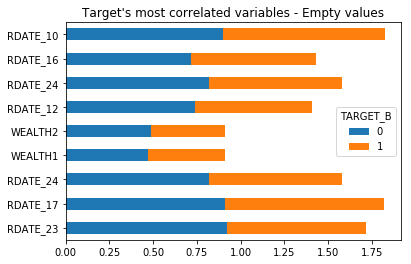

In [24]:
pd.concat([pdccg.iloc[[0]]/num_no, pdccg.iloc[[1]]/num_yes]).replace(0,np.nan).dropna(axis=1,how="all").T.plot(kind='barh', stacked=True)
plt.title("Target\'s most correlated variables - Empty values")

#### mean values by target of highly correlated columns 

In [25]:
rdtcc.groupby('TARGET_B').apply(lambda x: x.mean())#.replace(0,np.nan).dropna(axis=1,how="all").T.plot(kind='barh')

,RDATE_23,RDATE_17,CARDGIFT,RDATE_24,NGIFTALL,RFA_2F,IC19,WEALTH1,CARDPROM,HV4,EIC16,WEALTH2,IC10,HV3,OEDC3,RDATE_12,RDATE_24,LASTDATE,EC5,FEDGOV,HVP1,AFC6,RDATE_16,RDATE_10,RP4,ETHC5,NUMPROM,IC4,IC11,HVP2,TARGET_B
TARGET_B,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,9408.015873,9503.218447,4.897512,9407.248837,9.301139,1.882328,18.466470,5.364940,18.132855,3.919443,4.64108,5.014778,15.875580,4.262758,3.224378,9514.551780,9407.248837,9547.701814,20.852805,3.104597,14.059469,1.322649,9505.322870,9516.461538,76.873893,4.305778,46.306622,434.644876,5.651624,21.891607,0.0
1,9415.346154,9503.833333,6.527132,9410.064516,12.007752,2.201550,21.348837,6.041667,20.255814,4.449612,5.55814,5.594595,17.922481,4.736434,4.069767,9518.093023,9410.064516,9557.186047,22.170543,3.883721,18.813953,1.612403,9507.216216,9520.400000,80.922481,5.976744,50.124031,462.232558,6.589147,26.930233,1.0


In [26]:
ev = rdtcc.isnull().sum().sort_values(ascending=True)
ev

TARGET_B       0
AFC6           0
HVP1           0
FEDGOV         0
EC5            0
LASTDATE       0
NUMPROM        0
HVP2           0
OEDC3          0
HV3            0
ETHC5          0
IC10           0
EIC16          0
HV4            0
CARDPROM       0
IC19           0
RFA_2F         0
NGIFTALL       0
IC4            0
CARDGIFT       0
IC11           0
RP4            0
WEALTH1     1173
WEALTH2     1208
RDATE_16    1794
RDATE_12    1839
RDATE_24    2039
RDATE_24    2039
RDATE_10    2256
RDATE_17    2282
RDATE_23    2285
dtype: int64

Text(0.5, 1.0, "Target's most correlated variables - Empty values")

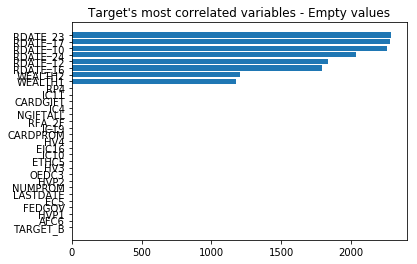

In [27]:
plt.barh(ev.index,ev.values)
plt.title('Target\'s most correlated variables - Empty values')

### column stats

In [28]:
raw_data_train.describe()

,ODATEDW,TCODE,DOB,CLUSTER,AGE,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,DATASRCE,MALEMILI,...,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,HPHONE_D,RFA_2F,CLUSTER2,TARGET_B
count,2500.000000,2500.000000,2500.000000,2427.000000,1864.000000,348.000000,1960.000000,1327.000000,2500.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1960.000000,2500.00000,...,218.000000,526.000000,389.000000,183.000000,238.000000,581.000000,215.000000,461.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2228.000000,2228.000000,2500.000000,2500.000000,2500.000000,2494.000000,2500.000000
mean,9155.091600,86.978000,2724.475200,27.407087,61.297747,1.436782,3.906122,5.401658,2.917200,0.132420,0.043836,1.127854,0.050228,0.407306,0.114155,0.053881,0.124201,0.147945,0.675799,0.229224,0.325114,0.006393,0.211872,2.469898,1.03120,...,13.440367,12.463441,13.318766,14.986339,12.310924,12.608434,12.504651,11.354664,104.000388,9.440800,4.981600,8.163728,9263.148800,20.438536,9443.906000,17.540836,9548.191200,9147.354400,9160.595601,7.878366,13.666778,0.490400,1.898800,30.883721,0.051600
std,343.118534,1307.083585,2142.045026,14.441795,16.570248,0.699133,1.847245,2.750965,6.303764,0.435826,0.237860,1.694733,0.249748,0.781611,0.366228,0.241531,0.471402,0.403405,1.210824,0.732795,0.899044,0.079735,0.770126,0.675625,4.90182,...,11.728048,9.287138,10.502880,12.254673,7.645906,8.822011,10.467461,9.466102,103.274630,8.584077,4.596707,7.676641,262.824717,16.496003,171.575134,11.435918,50.111635,316.265215,296.100836,6.147346,9.782692,0.500008,1.067059,18.736763,0.221262
min,8306.000000,0.000000,0.000000,1.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,...,2.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,2.000000,15.000000,1.000000,0.000000,0.000000,8608.000000,5.000000,8609.000000,0.000000,9503.000000,8306.000000,8309.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000
25%,8901.000000,0.000000,0.000000,14.000000,48.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.00000,...,7.000000,7.000000,7.000000,9.000000,7.000000,7.000000,6.000000,5.000000,40.000000,3.000000,2.000000,3.000000,9102.000000,15.000000,9409.000000,10.000000,9509.000000,8903.000000,8905.000000,3.000000,8.468326,0.000000,1.000000,14.000000,0.000000
50%,9201.000000,1.000000,2703.500000,27.000000,62.000000,1.000000,4.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,...,10.000000,10.000000,11.000000,12.000000,10.000000,10.000000,10.000000,10.000000,75.000000,7.000000,3.000000,5.000000,9310.000000,18.000000,9506.000000,15.000000,9512.000000,9203.000000,9205.000000,6.000000,11.878676,0.000000,1.000000,31.000000,0.000000
75%,9501.000000,2.000000,4508.250000,40.000000,74.000000,2.000000,5.000000,8.000000,3.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,...,16.000000,15.000000,16.000000,20.000000,15.000000,15.000000,15.000000,15.000000,134.000000,13.000000,7.000000,10.000000,9505.000000,25.000000,9512.000000,20.000000,9602.000000,9410.000000,9411.000000,11.000000,16.262500,1.000000,3.000000,49.000000,0.000000
max,9601.000000,39002.000000,7810.000000,53.000000,98

In [29]:
raw_data_validate.head()

,CONTROLN,TARGET_B
0,177658,0
1,97648,0
2,116053,0
3,109240,0
4,93585,0


### remove faulty columns

In [30]:
faulty_columns = ["ZIP"]
def remove_faulty_columns():
    ## remove from dataset
    #for c in faulty_columns:
    raw_data_train.drop(faulty_columns, axis=1, inplace=True)
    raw_data_test.drop(faulty_columns, axis=1, inplace=True)

In [31]:
raw_data_train.dtypes.head()

ODATEDW     int64
OSOURCE    object
TCODE       int64
STATE      object
ZIP        object
dtype: object

### remove unimportant variables according to randomForestClassifier (see below)

In [32]:
def remove_unimportant_var_randomForest():
    var_to_remove = ["ADATE_2","ADATE_5","RAMNT_4","RAMNT_3","ADATE_15","SOLP3","RDATE_4","RDATE_3","MAXADATE"]
    raw_data_train.drop(var_to_remove, axis=1, inplace=True)
    raw_data_test.drop(var_to_remove, axis=1, inplace=True)

### align column values (for dummification)

In [33]:
def align_variable_values_for_dummification():
    global raw_data_train, raw_data_test
    all_data_ = pd.concat((raw_data_train,raw_data_test))
    for column in all_data_.select_dtypes(include=['category','object']).columns:
        # fill categorical with most common value
        all_data_ = all_data_.fillna(all_data_[column].value_counts().index[0])
        
        cunique = all_data_[column].unique()
        raw_data_train[column] = raw_data_train[column].astype('category', categories = cunique)
        raw_data_test[column] = raw_data_test[column].astype('category', categories = cunique)

In [34]:
# include=['category'] if  align_variable_values_and_fill_categorical_most_common executed
categorical_columns = raw_data_train.select_dtypes(include=['object','category']).columns
raw_data_train[categorical_columns][20:30].describe()

,OSOURCE,STATE,ZIP,MAILCODE,PVASTATE,NOEXCH,RECINHSE,RECP3,RECPGVG,RECSWEEP,MDMAUD,DOMAIN,AGEFLAG,HOMEOWNR,CHILD03,CHILD07,CHILD12,CHILD18,GENDER,MAJOR,COLLECT1,VETERANS,BIBLE,CATLG,HOMEE,...,RFA_6,RFA_7,RFA_8,RFA_9,RFA_10,RFA_11,RFA_12,RFA_13,RFA_14,RFA_15,RFA_16,RFA_17,RFA_18,RFA_19,RFA_20,RFA_21,RFA_22,RFA_23,RFA_24,RFA_2R,RFA_2A,MDMAUD_R,MDMAUD_F,MDMAUD_A,GEOCODE2
count,10,10,10,0.0,1,10,0.0,0.0,0.0,1,10,10,6,9,0.0,0.0,0.0,0.0,10,0.0,1,0.0,3,1,2,...,10,7,8,10,6,9,9,4,7,0.0,8,6,6,7,5,7,7,4,6,10,10,10,10,10,10
unique,8,4,10,0.0,1,1,0.0,0.0,0.0,1,1,8,2,2,0.0,0.0,0.0,0.0,3,0.0,1,0.0,1,1,1,...,9,5,6,9,4,7,7,3,6,0.0,8,4,4,6,5,7,7,4,6,1,3,1,1,1,4
top,FRC,CA,74932,NaN,P,0,NaN,NaN,NaN,X,XXXX,R2,E,H,NaN,NaN,NaN,NaN,F,NaN,Y,NaN,Y,Y,Y,...,A1F,A1F,A1F,A1F,A1F,A1F,A1F,A1F,A1F,NaN,S2F,A1E,A1E,A1E,A1E,L1F,L1F,A1E,A1E,L,G,X,X,X,B
freq,2,3,1,NaN,1,10,NaN,NaN,NaN,1,10,3,5,7,NaN,NaN,NaN,NaN,6,NaN,1,NaN,3,1,2,...,2,3,3,2,3,3,3,2,2,NaN,1,3,3,2,1,1,1,1,1,10,4,10,10,10,5


In [35]:
pd.get_dummies(raw_data_train[categorical_columns]).shape

(2500, 4222)

In [36]:
numerical_columns = raw_data_train.select_dtypes(include=['int64','float64']).columns
raw_data_train[numerical_columns].describe()

,ODATEDW,TCODE,DOB,CLUSTER,AGE,NUMCHLD,INCOME,WEALTH1,HIT,MBCRAFT,MBGARDEN,MBBOOKS,MBCOLECT,MAGFAML,MAGFEM,MAGMALE,PUBGARDN,PUBCULIN,PUBHLTH,PUBDOITY,PUBNEWFN,PUBPHOTO,PUBOPP,DATASRCE,MALEMILI,...,RAMNT_17,RAMNT_18,RAMNT_19,RAMNT_20,RAMNT_21,RAMNT_22,RAMNT_23,RAMNT_24,RAMNTALL,NGIFTALL,CARDGIFT,MINRAMNT,MINRDATE,MAXRAMNT,MAXRDATE,LASTGIFT,LASTDATE,FISTDATE,NEXTDATE,TIMELAG,AVGGIFT,HPHONE_D,RFA_2F,CLUSTER2,TARGET_B
count,2500.000000,2500.000000,2500.000000,2427.000000,1864.000000,348.000000,1960.000000,1327.000000,2500.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1095.000000,1960.000000,2500.00000,...,218.000000,526.000000,389.000000,183.000000,238.000000,581.000000,215.000000,461.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2228.000000,2228.000000,2500.000000,2500.000000,2500.000000,2494.000000,2500.000000
mean,9155.091600,86.978000,2724.475200,27.407087,61.297747,1.436782,3.906122,5.401658,2.917200,0.132420,0.043836,1.127854,0.050228,0.407306,0.114155,0.053881,0.124201,0.147945,0.675799,0.229224,0.325114,0.006393,0.211872,2.469898,1.03120,...,13.440367,12.463441,13.318766,14.986339,12.310924,12.608434,12.504651,11.354664,104.000388,9.440800,4.981600,8.163728,9263.148800,20.438536,9443.906000,17.540836,9548.191200,9147.354400,9160.595601,7.878366,13.666778,0.490400,1.898800,30.883721,0.051600
std,343.118534,1307.083585,2142.045026,14.441795,16.570248,0.699133,1.847245,2.750965,6.303764,0.435826,0.237860,1.694733,0.249748,0.781611,0.366228,0.241531,0.471402,0.403405,1.210824,0.732795,0.899044,0.079735,0.770126,0.675625,4.90182,...,11.728048,9.287138,10.502880,12.254673,7.645906,8.822011,10.467461,9.466102,103.274630,8.584077,4.596707,7.676641,262.824717,16.496003,171.575134,11.435918,50.111635,316.265215,296.100836,6.147346,9.782692,0.500008,1.067059,18.736763,0.221262
min,8306.000000,0.000000,0.000000,1.000000,19.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,...,2.000000,2.000000,1.000000,3.000000,2.000000,1.000000,2.000000,2.000000,15.000000,1.000000,0.000000,0.000000,8608.000000,5.000000,8609.000000,0.000000,9503.000000,8306.000000,8309.000000,0.000000,2.000000,0.000000,1.000000,1.000000,0.000000
25%,8901.000000,0.000000,0.000000,14.000000,48.000000,1.000000,2.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.00000,...,7.000000,7.000000,7.000000,9.000000,7.000000,7.000000,6.000000,5.000000,40.000000,3.000000,2.000000,3.000000,9102.000000,15.000000,9409.000000,10.000000,9509.000000,8903.000000,8905.000000,3.000000,8.468326,0.000000,1.000000,14.000000,0.000000
50%,9201.000000,1.000000,2703.500000,27.000000,62.000000,1.000000,4.000000,6.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,...,10.000000,10.000000,11.000000,12.000000,10.000000,10.000000,10.000000,10.000000,75.000000,7.000000,3.000000,5.000000,9310.000000,18.000000,9506.000000,15.000000,9512.000000,9203.000000,9205.000000,6.000000,11.878676,0.000000,1.000000,31.000000,0.000000
75%,9501.000000,2.000000,4508.250000,40.000000,74.000000,2.000000,5.000000,8.000000,3.000000,0.000000,0.000000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,3.000000,0.00000,...,16.000000,15.000000,16.000000,20.000000,15.000000,15.000000,15.000000,15.000000,134.000000,13.000000,7.000000,10.000000,9505.000000,25.000000,9512.000000,20.000000,9602.000000,9410.000000,9411.000000,11.000000,16.262500,1.000000,3.000000,49.000000,0.000000
max,9601.000000,39002.000000,7810.000000,53.000000,98

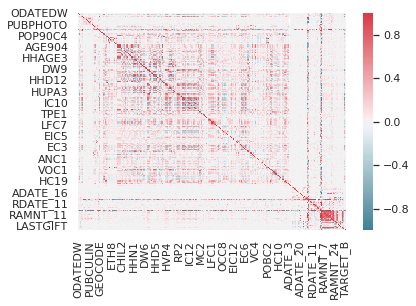

In [37]:
sns.set(style="white")
corr = raw_data_train.corr()
# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(corr, cmap=cmap, center=0)

### Remove highly correlated numerical columns

In [209]:
# remove
def remove_correlated_numerical_columns(factor=0.8):
    '''PRECONDITION'''
    #### align var for dummification '''PRECONDITION'''
    
    global raw_data_train, raw_data_test
    old_shape = raw_data_train.shape
    drop_target()
    categorical_columns = raw_data_train.select_dtypes(include=['object','category']).columns
    numerical_columns = raw_data_train.select_dtypes(include=['int64','float64']).columns
    uncorelated_num_columns, raw_data_train_numerical_new = trimm_correlated(raw_data_train[numerical_columns], factor)
    raw_data_test = pd.concat([raw_data_test[uncorelated_num_columns],raw_data_test[categorical_columns]], axis=1)
    raw_data_train = pd.concat([raw_data_train_numerical_new,raw_data_train[categorical_columns]], axis=1)
    new_shape = raw_data_train.shape
    assert raw_data_train.shape == raw_data_test.shape
    print("remove_correlated_numerical_columns- old", old_shape,",new:", new_shape)

Removing highly correlated column yields only 254 columns. Original number was 476.

In [41]:
expl(raw_data_train)

(2500, 476)
ODATEDW     2500
OSOURCE     2473
TCODE       2500
STATE       2500
ZIP         2500
MAILCODE      46
PVASTATE      42
DOB         2500
NOEXCH      2500
RECINHSE     171
RECP3         55
RECPGVG        6
RECSWEEP      46
MDMAUD      2500
DOMAIN      2427
CLUSTER     2427
AGE         1864
AGEFLAG     1740
HOMEOWNR    1928
CHILD03       24
CHILD07       38
CHILD12       57
CHILD18       73
NUMCHLD      348
INCOME      1960
GENDER      2433
WEALTH1     1327
HIT         2500
MBCRAFT     1095
MBGARDEN    1095
MBBOOKS     1095
MBCOLECT    1095
MAGFAML     1095
MAGFEM      1095
MAGMALE     1095
PUBGARDN    1095
PUBCULIN    1095
PUBHLTH     1095
PUBDOITY    1095
PUBNEWFN    1095
PUBPHOTO    1095
PUBOPP      1095
DATASRCE    1960
MALEMILI    2500
MALEVET     2500
VIETVETS    2500
WWIIVETS    2500
LOCALGOV    2500
STATEGOV    2500
FEDGOV      2500
            ... 
RDATE_18     526
RDATE_19     389
RDATE_20     183
RDATE_21     238
RDATE_22     581
RDATE_23     215
RDATE_24     461
RA

(None, None, None)

In [42]:
print(raw_data_train.isnull().sum().head())

ODATEDW     0
OSOURCE    27
TCODE       0
STATE       0
ZIP         0
dtype: int64


### Do some manual preprocessing 

In [43]:
# probably significant columns
add_target()
sc = ["AGE", "NUMCHLD","GENDER", "HOMEOWNR", "INCOME", "WEALTH1","WEALTH2","TARGET_B"]
rdtcc2 = raw_data_train[sc]
rdtcc2.groupby("TARGET_B").describe().unstack()

                TARGET_B
AGE      count  0           1774.000000
                1             90.000000
         mean   0             61.355693
                1             60.155556
         std    0             16.627917
                1             15.431553
         min    0             19.000000
                1             30.000000
         25%    0             48.000000
                1             49.000000
         50%    0             62.000000
                1             61.000000
         75%    0             74.000000
                1             73.000000
         max    0             98.000000
                1             88.000000
INCOME   count  0           1855.000000
                1            105.000000
         mean   0              3.891644
                1              4.161905
         std    0              1.852608
                1              1.738278
         min    0              1.000000
                1              1.000000
         25%   

### AGE
min    0             19.000000
                1             30.000000

In [44]:
rdtcc2.columns.values

array(['AGE', 'NUMCHLD', 'GENDER', 'HOMEOWNR', 'INCOME', 'WEALTH1',
       'WEALTH2', 'TARGET_B'], dtype=object)

Text(0.5, 1.0, 'Important categorical variables - Empty values')

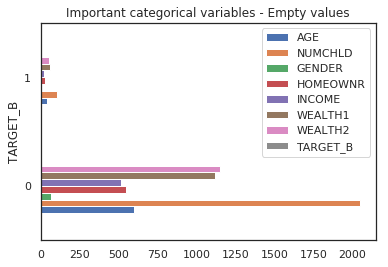

In [45]:
pdccg2 = rdtcc2.groupby('TARGET_B').apply(lambda x: x.isnull().sum()).plot(kind="barh")
plt.title("Important categorical variables - Empty values")

Text(0.5, 1.0, 'Important categorical variables - Empty values distribution')

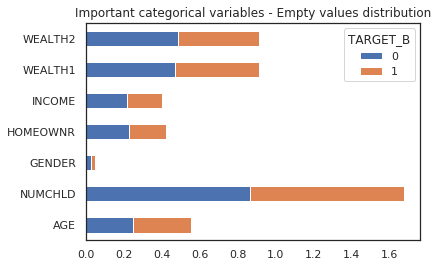

In [46]:
pdccg2 = rdtcc2.groupby('TARGET_B').apply(lambda x: x.isnull().sum())#.to_dict()
pdccg2.iloc[[0]]/num_no
pdccg2.iloc[[1]]/num_yes
pd.concat([pdccg2.iloc[[0]]/num_no, pdccg2.iloc[[1]]/num_yes]).replace(0,np.nan).dropna(axis=1,how="all").T.plot(kind='barh', stacked=True)
plt.title("Important categorical variables - Empty values distribution")

In [47]:
raw_data_train["TARGET_B"] = XY_train

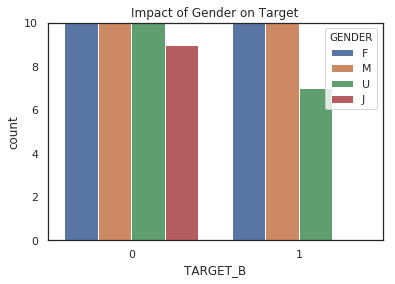

In [48]:
fig, ax=plt.subplots(figsize=(6,4))
sns.countplot(x='TARGET_B', data=raw_data_train, hue='GENDER')
ax.set_ylim(0,10)
plt.title("Impact of Gender on Target")
plt.show()

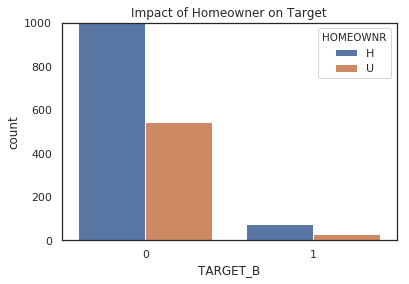

In [49]:
fig, ax=plt.subplots(figsize=(6,4))
sns.countplot(x='TARGET_B', data=raw_data_train, hue='HOMEOWNR')
ax.set_ylim(0,1000)
plt.title("Impact of Homeowner on Target")
plt.show()

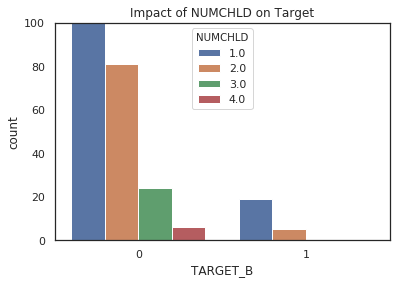

In [50]:
fig, ax=plt.subplots(figsize=(6,4))
sns.countplot(x='TARGET_B', data=raw_data_train, hue='NUMCHLD')
ax.set_ylim(0,100)
plt.title("Impact of NUMCHLD on Target")
plt.show()

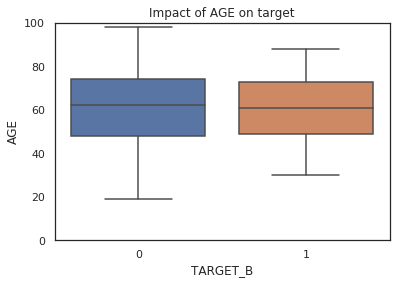

In [51]:

raw_data_train["TARGET_B"] = XY_train
fig, ax=plt.subplots(1, figsize=(6,4))
sns.boxplot(x='TARGET_B', data=raw_data_train, y='AGE')
ax.set_ylim(0,100)
plt.title("Impact of AGE on target")
plt.show()

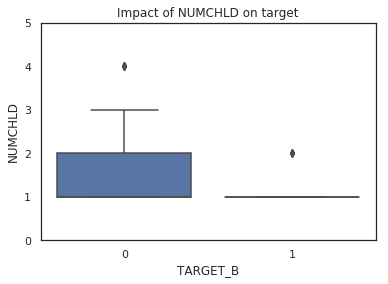

In [52]:
raw_data_train["TARGET_B"] = XY_train
fig, ax=plt.subplots(1, figsize=(6,4))
sns.boxplot(x='TARGET_B', data=raw_data_train, y='NUMCHLD')
ax.set_ylim(0,5)
plt.title("Impact of NUMCHLD on target")
plt.show()

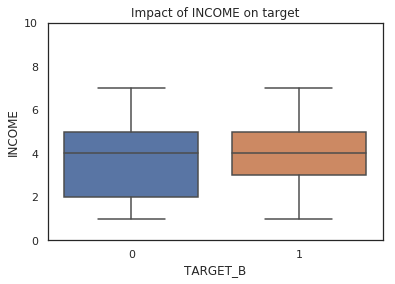

In [53]:
raw_data_train["TARGET_B"] = XY_train
fig, ax=plt.subplots(1, figsize=(6,4))
sns.boxplot(x='TARGET_B', data=raw_data_train, y='INCOME')
ax.set_ylim(0,10)
plt.title("Impact of INCOME on target")
plt.show()
#raw_data_train.drop(["TARGET_B"], inplace=True)

In [54]:
#raw_data_train.groupby(['TARGET_B'])["NOEXCH"].value_counts()
#count(raw_data_train[""])
#raw_data_train.loc[:, raw_data_train.dtypes.eq('object')].apply(pd.to_numeric, errors='coerce').apply(lambda x: x.isnull().sum()).head(10)
#raw_data_train.groupby(['TARGET_B'])["NOEXCH"].transform(lambda x: x.fillna(x.mode()[0]))
#raw_data_train.groupby(['TARGET_B'])["AGE"].transform('min')
#raw_data_train.groupby(['TARGET_B'])["INCOME"].quantile([.25])
no = raw_data_train.groupby(['TARGET_B'])["INCOME"].quantile([.25]).iloc[[0]].values[0]
yes = raw_data_train.groupby(['TARGET_B'])["INCOME"].quantile([.25]).iloc[[1]].values[0]
print(no,yes)
raw_data_train.loc[raw_data_train['TARGET_B'] == 0]["INCOME"].fillna(no).head(10)

2.0 3.0


0    2.0
1    5.0
2    7.0
3    6.0
4    2.0
5    3.0
6    5.0
7    2.0
8    2.0
9    2.0
Name: INCOME, dtype: float64

In [194]:
# NUMCHLD nan -> 0
# INCOME nan -> mean
# WEALTH1 nan -> mean

def impute_zero():
    raw_data_train.fillna(0,axis=1, inplace=True)
    raw_data_test.fillna(0,axis=1, inplace=True)

def fill_age_with_min_by_target():
    global raw_data_train, raw_data_test
    column = "AGE"
    # TODO align this shit
    raw_data_train[column] = raw_data_train.groupby(['TARGET_B'])[column].transform('min')
    raw_data_test[column] = raw_data_test.groupby(['TARGET_B'])[column].transform('min')

def fill_child_with_zero():
    global raw_data_train, raw_data_test
    # TODO align this shit
    raw_data_train["NUMCHLD"].fillna(0, inplace=True)
    raw_data_test["NUMCHLD"].fillna(0, inplace=True)
    
def fill_child_with_max_by_target():
    global raw_data_train, raw_data_test
    column = "NUMCHLD"
    raw_data_train[column] = raw_data_train.groupby(['TARGET_B'])[column].transform('max')
    raw_data_test[column] = raw_data_test.groupby(['TARGET_B'])[column].transform('max')

def fill_income_with_quantile_by_target():
    global raw_data_train, raw_data_test
    # select quantiles
    no = raw_data_train.groupby(['TARGET_B'])["INCOME"].quantile([.25]).iloc[[0]].values[0]
    yes = raw_data_train.groupby(['TARGET_B'])["INCOME"].quantile([.25]).iloc[[1]].values[0]
    # fill in quantiles
    raw_data_train.loc[raw_data_train['TARGET_B'] == 0]["INCOME"].fillna(no, inplace=True)
    raw_data_train.loc[raw_data_train['TARGET_B'] == 1]["INCOME"].fillna(yes, inplace=True)
    
    raw_data_test.loc[raw_data_test['TARGET_B'] == 0]["INCOME"].fillna(no, inplace=True)
    raw_data_test.loc[raw_data_test['TARGET_B'] == 1]["INCOME"].fillna(yes, inplace=True)
    
    
def convert_zip_to_numerical():
    global raw_data_train, raw_data_test
    # TODO align this shit
    raw_data_train["ZIP"] = raw_data_train["ZIP"].apply(pd.to_numeric, errors='coerce')
    raw_data_test["ZIP"] = raw_data_test["ZIP"].apply(pd.to_numeric, errors='coerce')

def fill_numerical_by_target_mean():
    global raw_data_train, raw_data_test, XY_sample_train
    raw_data_train[target_var] = XY_sample_train
    for column in raw_data_train.columns:
        # if is numerical
        if np.issubdtype(raw_data_train[column].dtype, np.number):
            raw_data_train[column] = raw_data_train.groupby(['TARGET_B'])[column].transform('mean')
            raw_data_test[column] = raw_data_test.groupby(['TARGET_B'])[column].transform('mean')

def fill_categorical_by_target_mostfrequent():
    global raw_data_train, raw_data_test
    add_target()
    categorical_columns = raw_data_train.select_dtypes(include=['object','category']).columns
    for column in raw_data_train.columns:
        print(column)
        print(raw_data_train.groupby(['TARGET_B'])[column].transform(lambda x: x.fillna(x.mode()[0])))
        #raw_data_train[column] = raw_data_train.groupby(['TARGET_B'])[column].transform(lambda x: x.fillna(x.mode()[0]))
        #raw_data_test[column] = raw_data_test.groupby(['TARGET_B'])[column].transform(lambda x: x.fillna(x.mode()[0]))
        

''' precondition '''
def impute_all_by_column_most_frequent():
    global raw_data_train, raw_data_test
    ### precondition
    align_variable_values_for_dummification()
    shape()
    drop_target()
    #raw_data_train.fillna(raw_data_train.mean(),inplace=True)
    # TODO align this shit
    raw_data_train.fillna(raw_data_train.mode().iloc[0], inplace=True)
    raw_data_test.fillna(raw_data_test.mode().iloc[0], inplace=True)

def impute_all_by_column_mean():
    global raw_data_train, raw_data_test
    shape()
    drop_target()
    # TODO align this shit
    columns = raw_data_train.select_dtypes(include=['int64','float64']).columns
    for column in columns:#raw_data_train.columns:
        raw_data_train[column].fillna(raw_data_train[column].mean(),inplace=True)
        raw_data_test[column].fillna(raw_data_test[column].mean(),inplace=True)
    
    
def impute_all_by_column_median():
    global raw_data_train, raw_data_test
    shape()
    drop_target()
    # TODO align this shit
    raw_data_train.fillna(raw_data_train.median(),inplace=True)
    raw_data_test.fillna(raw_data_test.median(),inplace=True)


In [61]:
shape()

(2500, 476) (2500, 476)


### remove unsignificant categorical variables

In [214]:
### tested on significance to target variable
def remove_unimportant_categorical(debug=False):
    global raw_data_train, raw_data_test, XY_train
    drop_target()
    
    start_shape = raw_data_train.shape
    unimportant_vars = []
    important_vars = []
    categorical_columns_data = raw_data_train.select_dtypes(include=['object','category'])#.columns
    for var in categorical_columns_data.columns: 
        csq=chi2_contingency(pd.crosstab(raw_data_train[var], XY_train))
        if csq[1] < 0.05:
            if debug:
                print(var, "P-value: ",csq[1])
            important_vars.append(var)
        else:
            unimportant_vars.append(var)

    if debug:
        print("remove_unimportant_categorical - removed:", len(unimportant_vars) )
    # TODO improve
    raw_data_train_numerical = raw_data_train.drop(categorical_columns_data.columns, axis=1)
    raw_data_test_numerical = raw_data_test.drop(categorical_columns_data.columns, axis=1)
    
    raw_data_train = pd.concat([categorical_columns_data[important_vars], raw_data_train_numerical], axis=1)
    raw_data_test = pd.concat([categorical_columns_data[important_vars], raw_data_test_numerical], axis=1)
    end_shape = raw_data_train.shape
    if debug:
        print("remove_unimportant_categorical - old:",start_shape,",new:",end_shape)
    assert raw_data_train.shape == raw_data_test.shape

In [65]:
raw_data_train.dtypes.head()

ODATEDW     int64
OSOURCE    object
TCODE       int64
STATE      object
ZIP        object
dtype: object

### binarize/dummify categorical data

In [221]:
# use this to dummify categorical and to improve logistic regression performance
''' 
precondition: align_variable_values_for_dummification()
- dimensions must be the same
'''
def dummify_categorical(debug=False):
    global raw_data_train, raw_data_test, XY_train
    drop_target()
    
    start_shape = raw_data_train.shape
    # precondition
    #align_variable_values_for_dummification()
    
    categorical_columns = raw_data_train.select_dtypes(include=['object','category']).columns
    if debug:
        print("categorical:",categorical_columns.values)
    
    train_categorical_binarized = pd.get_dummies(raw_data_train[categorical_columns])
    test_categorical_binarized = pd.get_dummies(raw_data_test[categorical_columns])
    
    raw_data_train_numerical = raw_data_train.drop(categorical_columns, axis=1)
    raw_data_test_numerical = raw_data_test.drop(categorical_columns, axis=1)
    if debug:
        print("numerical:",raw_data_train_numerical.values)
        #print("numerical:",raw_data_test_numerical.values)
    # TODO align train test
    raw_data_train = pd.concat([train_categorical_binarized,raw_data_train_numerical],axis=1)
    raw_data_test = pd.concat([test_categorical_binarized,raw_data_test_numerical],axis=1)
    
    #raw_data_train = raw_data_train.join(train_categorical_binarized)
    #raw_data_test = raw_data_test.join(test_categorical_binarized)
    end_shape = raw_data_train.shape
    #if debug:
    print("old:",start_shape,",new:",end_shape)
    assert raw_data_train.shape == raw_data_test.shape

### use this for categorical factorization (no dummies)

In [222]:
def factorize_categorical(debug=True):
    global raw_data_train, raw_data_test
    drop_target()
    
    start_shape = raw_data_train.shape
    categorical_columns = raw_data_train.select_dtypes(include=['object','category']).columns
    raw_data_train_c = raw_data_train[categorical_columns]
    raw_data_test_c = raw_data_test[categorical_columns]
    
    ## TODO align this shit
    raw_data_train_categorical = pd.DataFrame(raw_data_train_c.apply(lambda x: pd.factorize(x)[0]))
    raw_data_test_categorical = pd.DataFrame(raw_data_test_c.apply(lambda x: pd.factorize(x)[0]))
    
    raw_data_train.drop(categorical_columns, axis=1, inplace=True)
    raw_data_test.drop(categorical_columns, axis=1,inplace=True)
    
    raw_data_train = raw_data_train.join(raw_data_train_categorical)
    raw_data_test = raw_data_test.join(raw_data_test_categorical)
    
    #if '0' in raw_data_train.columns:
    #    raw_data_train.drop('0', axis=1, inplace=True)
    #if '0' in raw_data_test.columns:
    #    raw_data_test.drop('0', axis=1, inplace=True)
    
    raw_data_train.dropna(axis='columns', how='all', inplace=True)
    raw_data_test.dropna(axis='columns', how='all', inplace=True)
    
    end_shape = raw_data_train.shape
    if debug:
        print("factorize_categorical, old:",start_shape,",new:",end_shape)
    assert raw_data_train.shape == raw_data_test.shape

### Target class distribution (prior)

In [278]:
XY_train.value_counts()

0    2371
1     129
Name: TARGET_B, dtype: int64

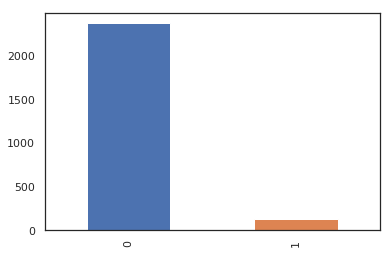

In [279]:
XY_train.value_counts().plot(kind='bar')

## balanced sampling - under/over sampling

In [116]:
def balanced_sampling(norm=False):
    ''' Undersampling & Oversampling strategy '''
    
    add_target()
    class_yes = raw_data_train.loc[raw_data_train['TARGET_B'] == 1]
    #class_yes
    class_no = raw_data_train.loc[raw_data_train['TARGET_B'] == 0]

    # seen data is 80%
    #n_percentage = 80/100
    #class_yes_train = class_yes.head(int(len(class_yes)*(n_percentage)))
    train_yes, test_yes = train_test_split(class_yes, test_size=0.2, random_state=6778)
    train_no, test_no = train_test_split(class_no, test_size=0.6, random_state=6778)
    print("Seen train:", train_yes.shape, train_no.shape)
    print("UnSeen test:", test_yes.shape, test_no.shape)

    n_train = max(train_yes.shape, train_no.shape)[0]
    n_test = max(test_yes.shape, test_no.shape)[0]

    # seen
    yes_train_big = train_yes.sample(n=n_train, replace=True, random_state=6778)
    no_train_big = train_no.sample(n=n_train, replace=False,random_state=6778)
    # unseen
    yes_test_big = test_yes.sample(n=n_test, replace=True,random_state=6778)
    no_test_big = test_no.sample(n=n_test, replace=False,random_state=6778)

    # oversampling
    X_train_big = pd.concat((yes_train_big, no_train_big))
    X_test_big = pd.concat((yes_test_big, no_test_big))


    # shuffle rows
    X_train_big = X_train_big.sample(frac=1).reset_index(drop=True)
    X_test_big = X_test_big.sample(frac=1).reset_index(drop=True)
    # make new target variable
    Y_train_big = X_train_big["TARGET_B"]
    Y_test_big = X_test_big["TARGET_B"]
    # drop target from X
    X_train_big.drop(["TARGET_B"], axis=1, inplace=True)
    X_test_big.drop(["TARGET_B"], axis=1, inplace=True)


    # scale
    if norm:
        scaler = MinMaxScaler()
        X_train_big = scaler.fit_transform(X_train_big)
        X_test_big = scaler.transform(X_test_big)
    
    print("X_train shape:", X_train_big.shape)
    print("X_test shape:", X_test_big.shape)
    print("Y_train shape:", Y_train_big.shape)
    print("Y_test shape:", Y_test_big.shape)
    return [X_train_big, X_test_big, Y_train_big, Y_test_big]

In [293]:
# sample balanced and shuffled
X_train, X_test, y_train, y_test = balanced_sampling()

Seen train: (103, 477) (948, 477)
UnSeen test: (26, 477) (1423, 477)
X_train shape: (1896, 476)
X_test shape: (2846, 476)
Y_train shape: (1896,)
Y_test shape: (2846,)


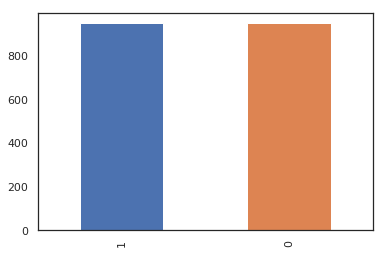

In [294]:
### target var distribution (post-processing)
y_train.value_counts().plot(kind='bar')

###  SMOTE Algorithm

In [295]:
'''
os = SMOTE(random_state=123)

X_dummies.drop(["TARGET_B"], axis=1, inplace=True)

os_data_X,os_data_y = os.fit_sample(X_dummies, y_train)
os_data_X = pd.DataFrame(data=os_data_X,columns=X_dummies.columns )
os_data_y = pd.DataFrame(data=os_data_y, columns=['TARGET_B'])
'''

'\nos = SMOTE(random_state=123)\n\nX_dummies.drop(["TARGET_B"], axis=1, inplace=True)\n\nos_data_X,os_data_y = os.fit_sample(X_dummies, y_train)\nos_data_X = pd.DataFrame(data=os_data_X,columns=X_dummies.columns )\nos_data_y = pd.DataFrame(data=os_data_y, columns=[\'TARGET_B\'])\n'

### TODO KNN imputation

In [296]:
'''
from fancyimpute import KNN    
# X is the complete data matrix
# X_incomplete has the same values as X except a subset have been replace with NaN

# Use 3 nearest rows which have a feature to fill in each row's missing features
#X_filled_knn = KNN(k=3).complete(X_incomplete)
'''

"\nfrom fancyimpute import KNN    \n# X is the complete data matrix\n# X_incomplete has the same values as X except a subset have been replace with NaN\n\n# Use 3 nearest rows which have a feature to fill in each row's missing features\n#X_filled_knn = KNN(k=3).complete(X_incomplete)\n"

### Check if no empty cells

In [297]:
X_sample.isnull().values.any()

False

## BASELINE - (oversampling)
- (fill column ZERO values)
- (fill column ZERO common)
- (factorize)

In [236]:
## Basic Preprocessing
load_data()

impute_zero()
no_empty_cells()
factorize_categorical()

# sample balanced and shuffled
X_train, X_test, y_train, y_test = balanced_sampling()
# normalized
X_train_norm, X_test_norm, y_train_norm, y_test_norm = balanced_sampling(True)

df1 = run_tests(0.8, "Zero", X_train, X_test, y_train, y_test, log=False)
df2 = run_tests(0.8, "Zero&Norm", X_train_norm, X_test_norm, y_train_norm, y_test_norm, log=False)

dff = pd.concat([df1,df2],axis=0)
dff.sort_values(by=['F1'], ascending=False, inplace=True)
dff

Tokenization took: 42.86 ms
Type conversion took: 99.94 ms
Parser memory cleanup took: 0.03 ms
EMPTY COLUMNS: ['RDATE_5' 'RAMNT_5']
Tokenization took: 26.51 ms
Type conversion took: 83.85 ms
Parser memory cleanup took: 0.03 ms
Tokenization took: 0.16 ms
Type conversion took: 0.43 ms
Parser memory cleanup took: 0.02 ms
factorize_categorical, old: (2500, 476) ,new: (2500, 476)
Seen train: (103, 477) (948, 477)
UnSeen test: (26, 477) (1423, 477)
X_train shape: (1896, 476)
X_test shape: (2846, 476)
Y_train shape: (1896,)
Y_test shape: (2846,)
Seen train: (103, 477) (948, 477)
UnSeen test: (26, 477) (1423, 477)
X_train shape: (1896, 476)
X_test shape: (2846, 476)
Y_train shape: (1896,)
Y_test shape: (2846,)


,Algorithm,F1,recall,precision,score,accuracy,Xsize,fit_time,pred_time,testSize,Setting
0,Naive Bayes,0.64,0.85,0.52,0.526704,0.53,"(1896, 476)",0.018,0.026,0.8,meanMFreq
0,Naive Bayes,0.63,0.88,0.49,0.481377,0.48,"(1896, 476)",0.017,0.023,0.8,meanMFreqNorm
0,SVM,0.59,0.57,0.61,0.601897,0.60,"(1896, 476)",2.304,3.449,0.8,meanMFreqNorm
0,KNN,0.52,0.43,0.64,0.595221,0.60,"(1896, 476)",0.031,3.090,0.8,meanMFreqNorm
0,LogisticRegression,0.44,0.34,0.61,0.562193,0.56,"(1896, 476)",9.220,0.005,0.8,meanMFreq
0,LogisticRegression,0.36,0.26,0.58,0.534434,0.53,"(1896, 476)",0.281,0.002,0.8,meanMFreqNorm
0,OneR,0.32,0.23,0.50,0.501054,0.50,"(1896, 476)",0.024,0.005,0.8,meanMFreq
0,KNN,0.32,0.24,0.52,0.509838,0.51,"(1896, 476)",0.045,2.316,0.8,meanMFreq
0,OneR,0.32,0.23,0.50,0.501054,0.50,"(1896, 476)",0.023,0.002,0.8,meanMFreqNorm
0,DecisionTree,0.19,0.12,0.47,0.493324,0.49,"(1896, 476)",0.185,0.005,0.8,meanMFreq


## BASELINE - (oversampling)
- (fill column mean values)
- (fill column most common)
- (factorize)

In [230]:
## Basic Preprocessing
load_data()
# convert obje
impute_all_by_column_mean()
impute_all_by_column_most_frequent()
no_empty_cells()
factorize_categorical()

# sample balanced and shuffled
X_train, X_test, y_train, y_test = balanced_sampling()
# normalized
X_train_norm, X_test_norm, y_train_norm, y_test_norm = balanced_sampling(True)

df1 = run_tests(0.8, "meanMFreq", X_train, X_test, y_train, y_test, log=False)
df2 = run_tests(0.8, "meanMFreqNorm", X_train_norm, X_test_norm, y_train_norm, y_test_norm, log=False)

dff = pd.concat([df1,df2],axis=0)
dff.sort_values(by=['F1'], ascending=False, inplace=True)
dff

Tokenization took: 42.83 ms
Type conversion took: 109.88 ms
Parser memory cleanup took: 0.03 ms
EMPTY COLUMNS: ['RDATE_5' 'RAMNT_5']
Tokenization took: 30.68 ms
Type conversion took: 84.91 ms
Parser memory cleanup took: 0.03 ms
Tokenization took: 0.22 ms
Type conversion took: 0.52 ms
Parser memory cleanup took: 0.01 ms
(2500, 476) (2500, 476)
(2500, 476) (2500, 476)
factorize_categorical, old: (2500, 476) ,new: (2500, 476)
Seen train: (103, 477) (948, 477)
UnSeen test: (26, 477) (1423, 477)
X_train shape: (1896, 476)
X_test shape: (2846, 476)
Y_train shape: (1896,)
Y_test shape: (2846,)
Seen train: (103, 477) (948, 477)
UnSeen test: (26, 477) (1423, 477)
X_train shape: (1896, 476)
X_test shape: (2846, 476)
Y_train shape: (1896,)
Y_test shape: (2846,)


,Algorithm,F1,recall,precision,score,accuracy,Xsize,fit_time,pred_time,testSize,Setting
0,Naive Bayes,0.64,0.88,0.50,0.496486,0.50,"(1896, 476)",0.014,0.021,0.8,meanMFreqNorm
0,Naive Bayes,0.49,0.55,0.44,0.432186,0.43,"(1896, 476)",0.015,0.019,0.8,meanMFreq
0,LogisticRegression,0.48,0.38,0.66,0.594519,0.59,"(1896, 476)",0.200,0.001,0.8,meanMFreqNorm
0,KNN,0.48,0.39,0.62,0.575896,0.58,"(1896, 476)",0.030,2.413,0.8,meanMFreqNorm
0,SVM,0.41,0.33,0.53,0.519325,0.52,"(1896, 476)",2.279,2.762,0.8,meanMFreqNorm
0,LogisticRegression,0.37,0.27,0.58,0.537597,0.54,"(1896, 476)",5.426,0.004,0.8,meanMFreq
0,KNN,0.36,0.27,0.53,0.515109,0.52,"(1896, 476)",0.028,0.409,0.8,meanMFreq
0,OneR,0.32,0.23,0.50,0.501054,0.50,"(1896, 476)",0.021,0.004,0.8,meanMFreq
0,OneR,0.32,0.23,0.50,0.501054,0.50,"(1896, 476)",0.024,0.002,0.8,meanMFreqNorm
0,DecisionTree,0.19,0.12,0.47,0.493675,0.49,"(1896, 476)",0.202,0.005,0.8,meanMFreq


## BASELINE 1.2 - (oversampling)
-fill_child_with_zero
- (fill column mean values)
- (fill column most common)
- (factorize)

In [231]:
## Basic Preprocessing
load_data()
# convert obje
fill_child_with_zero()
impute_all_by_column_mean()
impute_all_by_column_most_frequent()
no_empty_cells()
factorize_categorical()


# sample balanced and shuffled
X_train, X_test, y_train, y_test = balanced_sampling()
# normalized
X_train_norm, X_test_norm, y_train_norm, y_test_norm = balanced_sampling(True)

df1 = run_tests(0.8, "C0meanMFreq", X_train, X_test, y_train, y_test, log=False)
df2 = run_tests(0.8, "C0meanMFreqNorm", X_train_norm, X_test_norm, y_train_norm, y_test_norm, log=False)

dff = pd.concat([df1,df2],axis=0)
dff.sort_values(by=['F1'], ascending=False, inplace=True)
dff

Tokenization took: 29.72 ms
Type conversion took: 99.26 ms
Parser memory cleanup took: 0.04 ms
EMPTY COLUMNS: ['RDATE_5' 'RAMNT_5']
Tokenization took: 23.73 ms
Type conversion took: 81.69 ms
Parser memory cleanup took: 0.03 ms
Tokenization took: 0.16 ms
Type conversion took: 0.41 ms
Parser memory cleanup took: 0.01 ms
(2500, 476) (2500, 476)
(2500, 476) (2500, 476)
factorize_categorical, old: (2500, 476) ,new: (2500, 476)
Seen train: (103, 477) (948, 477)
UnSeen test: (26, 477) (1423, 477)
X_train shape: (1896, 476)
X_test shape: (2846, 476)
Y_train shape: (1896,)
Y_test shape: (2846,)
Seen train: (103, 477) (948, 477)
UnSeen test: (26, 477) (1423, 477)
X_train shape: (1896, 476)
X_test shape: (2846, 476)
Y_train shape: (1896,)
Y_test shape: (2846,)


,Algorithm,F1,recall,precision,score,accuracy,Xsize,fit_time,pred_time,testSize,Setting
0,Naive Bayes,0.64,0.88,0.50,0.496486,0.50,"(1896, 476)",0.024,0.029,0.8,meanMFreqNorm
0,Naive Bayes,0.49,0.55,0.44,0.432186,0.43,"(1896, 476)",0.016,0.020,0.8,meanMFreq
0,LogisticRegression,0.48,0.38,0.66,0.593113,0.59,"(1896, 476)",0.479,0.002,0.8,meanMFreqNorm
0,KNN,0.44,0.35,0.60,0.559733,0.56,"(1896, 476)",0.050,2.041,0.8,meanMFreqNorm
0,SVM,0.41,0.33,0.53,0.518623,0.52,"(1896, 476)",2.206,3.206,0.8,meanMFreqNorm
0,LogisticRegression,0.40,0.30,0.60,0.552003,0.55,"(1896, 476)",5.162,0.004,0.8,meanMFreq
0,KNN,0.36,0.27,0.53,0.515109,0.52,"(1896, 476)",0.028,0.410,0.8,meanMFreq
0,OneR,0.32,0.23,0.50,0.501054,0.50,"(1896, 476)",0.023,0.004,0.8,meanMFreq
0,OneR,0.32,0.23,0.50,0.501054,0.50,"(1896, 476)",0.032,0.003,0.8,meanMFreqNorm
0,DecisionTree,0.19,0.12,0.47,0.493675,0.49,"(1896, 476)",0.195,0.005,0.8,meanMFreq


### BASELINE 2 - remove_correlated_numerical_columns
- (remove_correlated_numerical_columns)
- (fill column mean values)
- (fill column most common)
- (factorize)

In [232]:
## Basic Preprocessing
load_data()
remove_correlated_numerical_columns(0.8)
impute_all_by_column_mean()
impute_all_by_column_most_frequent()
factorize_categorical()
no_empty_cells()

# sample balanced and shuffled
X_train, X_test, y_train, y_test = balanced_sampling()
# normalized
X_train_norm, X_test_norm, y_train_norm, y_test_norm = balanced_sampling(True)

df1 = run_tests(0.8, "meanMFreq", X_train, X_test, y_train, y_test, log=False)
df2 = run_tests(0.8, "meanMFreqNorm", X_train_norm, X_test_norm, y_train_norm, y_test_norm, log=False)

dff = pd.concat([df1,df2],axis=0)
dff.sort_values(by=['F1'], ascending=False, inplace=True)
dff

Tokenization took: 29.07 ms
Type conversion took: 113.45 ms
Parser memory cleanup took: 0.06 ms
EMPTY COLUMNS: ['RDATE_5' 'RAMNT_5']
Tokenization took: 38.13 ms
Type conversion took: 201.72 ms
Parser memory cleanup took: 0.06 ms
Tokenization took: 0.33 ms
Type conversion took: 0.66 ms
Parser memory cleanup took: 0.01 ms
remove_correlated_numerical_columns- old (2500, 476) ,new: (2500, 322)
(2500, 322) (2500, 322)
(2500, 322) (2500, 322)
factorize_categorical, old: (2500, 322) ,new: (2500, 322)
Seen train: (103, 323) (948, 323)
UnSeen test: (26, 323) (1423, 323)
X_train shape: (1896, 322)
X_test shape: (2846, 322)
Y_train shape: (1896,)
Y_test shape: (2846,)
Seen train: (103, 323) (948, 323)
UnSeen test: (26, 323) (1423, 323)
X_train shape: (1896, 322)
X_test shape: (2846, 322)
Y_train shape: (1896,)
Y_test shape: (2846,)


,Algorithm,F1,recall,precision,score,accuracy,Xsize,fit_time,pred_time,testSize,Setting
0,OneR,0.66,0.93,0.52,0.531272,0.53,"(1896, 322)",0.026,0.005,0.8,meanMFreq
0,OneR,0.66,0.93,0.52,0.531272,0.53,"(1896, 322)",0.014,0.002,0.8,meanMFreqNorm
0,Naive Bayes,0.62,0.84,0.49,0.474350,0.47,"(1896, 322)",0.012,0.012,0.8,meanMFreqNorm
0,Naive Bayes,0.56,0.66,0.49,0.486648,0.49,"(1896, 322)",0.013,0.018,0.8,meanMFreq
0,LogisticRegression,0.54,0.46,0.67,0.617006,0.62,"(1896, 322)",0.152,0.002,0.8,meanMFreqNorm
0,KNN,0.49,0.40,0.61,0.574491,0.57,"(1896, 322)",0.021,0.311,0.8,meanMFreq
0,SVM,0.44,0.38,0.54,0.530921,0.53,"(1896, 322)",1.535,1.926,0.8,meanMFreqNorm
0,KNN,0.35,0.26,0.53,0.515109,0.52,"(1896, 322)",0.018,1.609,0.8,meanMFreqNorm
0,LogisticRegression,0.26,0.18,0.48,0.492621,0.49,"(1896, 322)",7.255,0.003,0.8,meanMFreq
0,DecisionTree,0.25,0.15,0.65,0.535137,0.54,"(1896, 322)",0.191,0.004,0.8,meanMFreq


### BASELINE 2.1 - corr columns 0.1
-corr factor 0.1
- (remove_correlated_numerical_columns)
- (fill column mean values)
- (fill column most common)
- (factorize)

In [233]:
## Basic Preprocessing
load_data()
remove_correlated_numerical_columns(0.1)
impute_all_by_column_mean()
impute_all_by_column_most_frequent()
factorize_categorical()
no_empty_cells()

# sample balanced and shuffled
X_train, X_test, y_train, y_test = balanced_sampling()
# normalized
X_train_norm, X_test_norm, y_train_norm, y_test_norm = balanced_sampling(True)

df1 = run_tests(0.8, "meanMFreq", X_train, X_test, y_train, y_test, log=False)
df2 = run_tests(0.8, "meanMFreqNorm", X_train_norm, X_test_norm, y_train_norm, y_test_norm, log=False)

dff = pd.concat([df1,df2],axis=0)
dff.sort_values(by=['F1'], ascending=False, inplace=True)
dff

Tokenization took: 41.90 ms
Type conversion took: 101.33 ms
Parser memory cleanup took: 0.03 ms
EMPTY COLUMNS: ['RDATE_5' 'RAMNT_5']
Tokenization took: 28.21 ms
Type conversion took: 87.72 ms
Parser memory cleanup took: 0.03 ms
Tokenization took: 0.16 ms
Type conversion took: 0.35 ms
Parser memory cleanup took: 0.01 ms
remove_correlated_numerical_columns- old (2500, 476) ,new: (2500, 78)
(2500, 78) (2500, 78)
(2500, 78) (2500, 78)
factorize_categorical, old: (2500, 78) ,new: (2500, 78)
Seen train: (103, 79) (948, 79)
UnSeen test: (26, 79) (1423, 79)
X_train shape: (1896, 78)
X_test shape: (2846, 78)
Y_train shape: (1896,)
Y_test shape: (2846,)
Seen train: (103, 79) (948, 79)
UnSeen test: (26, 79) (1423, 79)
X_train shape: (1896, 78)
X_test shape: (2846, 78)
Y_train shape: (1896,)
Y_test shape: (2846,)


,Algorithm,F1,recall,precision,score,accuracy,Xsize,fit_time,pred_time,testSize,Setting
0,Naive Bayes,0.67,1.00,0.50,0.505622,0.51,"(1896, 78)",0.004,0.005,0.8,meanMFreqNorm
0,OneR,0.66,0.93,0.52,0.531272,0.53,"(1896, 78)",0.007,0.002,0.8,meanMFreq
0,OneR,0.66,0.93,0.52,0.531272,0.53,"(1896, 78)",0.004,0.001,0.8,meanMFreqNorm
0,Naive Bayes,0.65,0.96,0.50,0.490864,0.49,"(1896, 78)",0.006,0.007,0.8,meanMFreq
0,LogisticRegression,0.58,0.54,0.63,0.612790,0.61,"(1896, 78)",0.687,0.002,0.8,meanMFreq
0,LogisticRegression,0.58,0.54,0.63,0.612439,0.61,"(1896, 78)",0.023,0.000,0.8,meanMFreqNorm
0,SVM,0.51,0.43,0.63,0.587843,0.59,"(1896, 78)",0.705,0.671,0.8,meanMFreqNorm
0,KNN,0.47,0.38,0.61,0.567814,0.57,"(1896, 78)",0.006,0.207,0.8,meanMFreq
0,DecisionTree,0.39,0.27,0.73,0.585734,0.59,"(1896, 78)",0.035,0.002,0.8,meanMFreq
0,DecisionTree,0.39,0.27,0.73,0.584680,0.58,"(1896, 78)",0.028,0.001,0.8,meanMFreqNorm


### BASELINE 3 - remove insignificant categorical
-remove insignificant categorical
- (fill column mean values)
- (fill column most common)
- (factorize)

In [234]:
load_data()

remove_unimportant_categorical(True)

impute_all_by_column_mean()
impute_all_by_column_most_frequent()
factorize_categorical()
raw_data_train.head()
no_empty_cells()

# sample balanced and shuffled
X_train, X_test, y_train, y_test = balanced_sampling()
# normalized
X_train_norm, X_test_norm, y_train_norm, y_test_norm = balanced_sampling(True)

df1 = run_tests(0.8, "meanMFreq", X_train, X_test, y_train, y_test, log=False)
df2 = run_tests(0.8, "meanMFreqNorm", X_train_norm, X_test_norm, y_train_norm, y_test_norm, log=False)

dff = pd.concat([df1,df2],axis=0)
dff.sort_values(by=['F1'], ascending=False, inplace=True)
dff

Tokenization took: 44.52 ms
Type conversion took: 134.41 ms
Parser memory cleanup took: 0.04 ms
EMPTY COLUMNS: ['RDATE_5' 'RAMNT_5']
Tokenization took: 30.17 ms
Type conversion took: 101.38 ms
Parser memory cleanup took: 0.03 ms
Tokenization took: 0.18 ms
Type conversion took: 0.32 ms
Parser memory cleanup took: 0.01 ms
GENDER P-value:  0.016959854417157978
RFA_2 P-value:  9.64398311188082e-06
RFA_13 P-value:  0.03056326433443548
RFA_14 P-value:  2.1695340849858885e-05
RFA_17 P-value:  0.0005613137670075881
RFA_18 P-value:  0.015248289813172639
RFA_20 P-value:  0.0001632408010852298
RFA_21 P-value:  0.0018308511470552966
RFA_22 P-value:  0.0003186921853730916
RFA_23 P-value:  0.011074206378483867
RFA_24 P-value:  0.006188434347074919
RFA_2A P-value:  7.246131647342235e-05
remove_unimportant_categorical - removed: 56
remove_unimportant_categorical - old: (2500, 476) ,new: (2500, 420)
(2500, 420) (2500, 420)
(2500, 420) (2500, 420)
factorize_categorical, old: (2500, 420) ,new: (2500, 420

,Algorithm,F1,recall,precision,score,accuracy,Xsize,fit_time,pred_time,testSize,Setting
0,Naive Bayes,0.64,0.88,0.50,0.504216,0.50,"(1896, 420)",0.013,0.018,0.8,meanMFreqNorm
0,Naive Bayes,0.49,0.55,0.44,0.431483,0.43,"(1896, 420)",0.019,0.026,0.8,meanMFreq
0,SVM,0.48,0.42,0.57,0.548489,0.55,"(1896, 420)",2.097,3.633,0.8,meanMFreqNorm
0,LogisticRegression,0.44,0.34,0.63,0.570977,0.57,"(1896, 420)",0.271,0.002,0.8,meanMFreqNorm
0,KNN,0.36,0.27,0.55,0.524947,0.52,"(1896, 420)",0.030,2.515,0.8,meanMFreqNorm
0,LogisticRegression,0.33,0.24,0.54,0.516866,0.52,"(1896, 420)",6.445,0.004,0.8,meanMFreq
0,KNN,0.33,0.24,0.51,0.504568,0.50,"(1896, 420)",0.029,0.612,0.8,meanMFreq
0,OneR,0.32,0.23,0.50,0.501054,0.50,"(1896, 420)",0.026,0.005,0.8,meanMFreq
0,OneR,0.32,0.23,0.50,0.501054,0.50,"(1896, 420)",0.022,0.002,0.8,meanMFreqNorm
0,DecisionTree,0.19,0.12,0.50,0.501054,0.50,"(1896, 420)",0.331,0.006,0.8,meanMFreq


### BASELINE 4 - remove ins. numerical&categorical 
-remove insignificant categorical
-remove_correlated_numerical_columns
- (fill column mean values)
- (fill column most common)
- (factorize)

In [235]:
load_data()

remove_unimportant_categorical(True)
remove_correlated_numerical_columns(0.4)

impute_all_by_column_mean()
impute_all_by_column_most_frequent()
factorize_categorical()
raw_data_train.head()
no_empty_cells()

# sample balanced and shuffled
X_train, X_test, y_train, y_test = balanced_sampling()
# normalized
X_train_norm, X_test_norm, y_train_norm, y_test_norm = balanced_sampling(True)

df1 = run_tests(0.8, "meanMFreq", X_train, X_test, y_train, y_test, log=False)
df2 = run_tests(0.8, "meanMFreqNorm", X_train_norm, X_test_norm, y_train_norm, y_test_norm, log=False)

dff = pd.concat([df1,df2],axis=0)
dff.sort_values(by=['F1'], ascending=False, inplace=True)
dff

Tokenization took: 32.01 ms
Type conversion took: 113.04 ms
Parser memory cleanup took: 0.05 ms
EMPTY COLUMNS: ['RDATE_5' 'RAMNT_5']
Tokenization took: 30.13 ms
Type conversion took: 101.56 ms
Parser memory cleanup took: 0.03 ms
Tokenization took: 0.18 ms
Type conversion took: 0.52 ms
Parser memory cleanup took: 0.01 ms
GENDER P-value:  0.016959854417157978
RFA_2 P-value:  9.64398311188082e-06
RFA_13 P-value:  0.03056326433443548
RFA_14 P-value:  2.1695340849858885e-05
RFA_17 P-value:  0.0005613137670075881
RFA_18 P-value:  0.015248289813172639
RFA_20 P-value:  0.0001632408010852298
RFA_21 P-value:  0.0018308511470552966
RFA_22 P-value:  0.0003186921853730916
RFA_23 P-value:  0.011074206378483867
RFA_24 P-value:  0.006188434347074919
RFA_2A P-value:  7.246131647342235e-05
remove_unimportant_categorical - removed: 56
remove_unimportant_categorical - old: (2500, 476) ,new: (2500, 420)
remove_correlated_numerical_columns- old (2500, 420) ,new: (2500, 78)
(2500, 78) (2500, 78)
(2500, 78) (

,Algorithm,F1,recall,precision,score,accuracy,Xsize,fit_time,pred_time,testSize,Setting
0,Naive Bayes,0.68,0.96,0.53,0.548840,0.55,"(1896, 78)",0.003,0.003,0.8,meanMFreqNorm
0,Naive Bayes,0.63,0.81,0.52,0.534786,0.53,"(1896, 78)",0.007,0.008,0.8,meanMFreq
0,SVM,0.55,0.51,0.60,0.586086,0.59,"(1896, 78)",0.475,0.587,0.8,meanMFreqNorm
0,LogisticRegression,0.49,0.42,0.57,0.554111,0.55,"(1896, 78)",1.169,0.002,0.8,meanMFreq
0,LogisticRegression,0.48,0.41,0.57,0.550246,0.55,"(1896, 78)",0.024,0.000,0.8,meanMFreqNorm
0,KNN,0.43,0.34,0.58,0.545327,0.55,"(1896, 78)",0.004,0.406,0.8,meanMFreqNorm
0,OneR,0.42,0.35,0.54,0.526704,0.53,"(1896, 78)",0.008,0.002,0.8,meanMFreq
0,OneR,0.42,0.35,0.54,0.526704,0.53,"(1896, 78)",0.003,0.000,0.8,meanMFreqNorm
0,KNN,0.36,0.27,0.53,0.515460,0.52,"(1896, 78)",0.005,0.106,0.8,meanMFreq
0,DecisionTree,0.06,0.04,0.24,0.459944,0.46,"(1896, 78)",0.075,0.003,0.8,meanMFreq


### BASELINE 5 - DUMMY
- (fill column ZERO values)
- DUMMY
- 6593 columns (long to train)

In [240]:
# setting 1
load_data()
impute_zero()
align_variable_values_for_dummification()
dummify_categorical(False)
no_empty_cells()

# sample balanced and shuffled
X_train, X_test, y_train, y_test = balanced_sampling()
# normalized
X_train_norm, X_test_norm, y_train_norm, y_test_norm = balanced_sampling(True)

df1 = run_tests(0.8, "Zero", X_train, X_test, y_train, y_test, log=True)
df2 = run_tests(0.8, "Zero&Norm", X_train_norm, X_test_norm, y_train_norm, y_test_norm, log=True)

dff = pd.concat([df1,df2],axis=0)
dff.sort_values(by=['F1'], ascending=False, inplace=True)
dff

Tokenization took: 44.17 ms
Type conversion took: 103.09 ms
Parser memory cleanup took: 0.04 ms
EMPTY COLUMNS: ['RDATE_5' 'RAMNT_5']
Tokenization took: 26.30 ms
Type conversion took: 88.32 ms
Parser memory cleanup took: 0.03 ms
Tokenization took: 0.21 ms
Type conversion took: 0.39 ms
Parser memory cleanup took: 0.01 ms
old: (2500, 476) ,new: (2500, 6593)
Seen train: (103, 6594) (948, 6594)
UnSeen test: (26, 6594) (1423, 6594)
X_train shape: (1896, 6593)
X_test shape: (2846, 6593)
Y_train shape: (1896,)
Y_test shape: (2846,)
Seen train: (103, 6594) (948, 6594)
UnSeen test: (26, 6594) (1423, 6594)
X_train shape: (1896, 6593)
X_test shape: (2846, 6593)
Y_train shape: (1896,)
Y_test shape: (2846,)
OneR ...fit
OneR ...score
OneR ...predict
OneR ...performance
OneR ...concat
(0, 0)
(1, 11)
RandomForest ...fit
RandomForest ...score
RandomForest ...predict
RandomForest ...performance
RandomForest ...concat
(1, 11)
(1, 11)
DecisionTree ...fit
DecisionTree ...score
DecisionTree ...predict
Decisi

,Algorithm,F1,recall,precision,score,accuracy,Xsize,fit_time,pred_time,testSize,Setting
0,Naive Bayes,0.65,0.85,0.53,0.540759,0.54,"(1896, 6593)",0.389,0.482,0.8,meanMFreq
0,SVM,0.59,0.53,0.65,0.622980,0.62,"(1896, 6593)",32.757,53.083,0.8,meanMFreqNorm
0,KNN,0.44,0.35,0.59,0.553760,0.55,"(1896, 6593)",0.946,41.015,0.8,meanMFreqNorm
0,LogisticRegression,0.36,0.26,0.56,0.526001,0.53,"(1896, 6593)",14.027,0.076,0.8,meanMFreq
0,LogisticRegression,0.34,0.23,0.72,0.569571,0.57,"(1896, 6593)",0.753,0.024,0.8,meanMFreqNorm
0,OneR,0.32,0.23,0.50,0.501054,0.50,"(1896, 6593)",0.115,0.099,0.8,meanMFreq
0,KNN,0.32,0.24,0.52,0.509487,0.51,"(1896, 6593)",0.832,36.690,0.8,meanMFreq
0,OneR,0.32,0.23,0.50,0.501054,0.50,"(1896, 6593)",0.092,0.056,0.8,meanMFreqNorm
0,Naive Bayes,0.32,0.22,0.59,0.532677,0.53,"(1896, 6593)",0.577,0.602,0.8,meanMFreqNorm
0,DecisionTree,0.13,0.08,0.38,0.477161,0.48,"(1896, 6593)",0.419,0.094,0.8,meanMFreq


### BASELINE 5.1 - DUMMY
- (fill column mean values)
- (fill column MostFrequent categorical))
  - 6593 columns (long to train)

In [ ]:
#setting 2
load_data()
impute_all_by_column_mean()
impute_all_by_column_most_frequent()
dummify_categorical(False)

no_empty_cells()

# sample balanced and shuffled
X_train, X_test, y_train, y_test = balanced_sampling()
# normalized
X_train_norm, X_test_norm, y_train_norm, y_test_norm = balanced_sampling(True)

df1 = run_tests(0.8, "meanMFreq", X_train, X_test, y_train, y_test, log=False)
df2 = run_tests(0.8, "meanMFreqNorm", X_train_norm, X_test_norm, y_train_norm, y_test_norm, log=False)

dff = pd.concat([df1,df2],axis=0)
dff.sort_values(by=['F1'], ascending=False, inplace=True)
dff

### BASELINE 5.2 - DUMMY
- (impute column ZERO values)
- (remove_unimportant_categorical)
  - 1118 columns 

In [241]:
load_data()
impute_zero()
remove_unimportant_categorical()
dummify_categorical(False)
no_empty_cells()

# sample balanced and shuffled
X_train, X_test, y_train, y_test = balanced_sampling()
# normalized
X_train_norm, X_test_norm, y_train_norm, y_test_norm = balanced_sampling(True)

df1 = run_tests(0.8, "Zero", X_train, X_test, y_train, y_test, log=False)
df2 = run_tests(0.8, "Zero&Norm", X_train_norm, X_test_norm, y_train_norm, y_test_norm, log=False)

dff = pd.concat([df1,df2],axis=0)
dff.sort_values(by=['F1'], ascending=False, inplace=True)
dff

Tokenization took: 31.86 ms
Type conversion took: 93.04 ms
Parser memory cleanup took: 0.02 ms
EMPTY COLUMNS: ['RDATE_5' 'RAMNT_5']
Tokenization took: 25.79 ms
Type conversion took: 82.50 ms
Parser memory cleanup took: 0.03 ms
Tokenization took: 0.16 ms
Type conversion took: 0.37 ms
Parser memory cleanup took: 0.01 ms
old: (2500, 421) ,new: (2500, 1118)
Seen train: (103, 1119) (948, 1119)
UnSeen test: (26, 1119) (1423, 1119)
X_train shape: (1896, 1118)
X_test shape: (2846, 1118)
Y_train shape: (1896,)
Y_test shape: (2846,)
Seen train: (103, 1119) (948, 1119)
UnSeen test: (26, 1119) (1423, 1119)
X_train shape: (1896, 1118)
X_test shape: (2846, 1118)
Y_train shape: (1896,)
Y_test shape: (2846,)


,Algorithm,F1,recall,precision,score,accuracy,Xsize,fit_time,pred_time,testSize,Setting
0,Naive Bayes,0.64,0.85,0.52,0.531975,0.53,"(1896, 1118)",0.046,0.067,0.8,meanMFreq
0,Naive Bayes,0.59,0.59,0.59,0.589599,0.59,"(1896, 1118)",0.044,0.038,0.8,meanMFreqNorm
0,SVM,0.59,0.57,0.62,0.611384,0.61,"(1896, 1118)",4.714,6.891,0.8,meanMFreqNorm
0,LogisticRegression,0.40,0.30,0.58,0.541462,0.54,"(1896, 1118)",8.712,0.007,0.8,meanMFreq
0,LogisticRegression,0.39,0.27,0.70,0.576599,0.58,"(1896, 1118)",0.224,0.003,0.8,meanMFreqNorm
0,KNN,0.35,0.26,0.51,0.507027,0.51,"(1896, 1118)",0.091,5.133,0.8,meanMFreqNorm
0,OneR,0.32,0.23,0.50,0.501054,0.50,"(1896, 1118)",0.032,0.010,0.8,meanMFreq
0,KNN,0.32,0.24,0.52,0.509487,0.51,"(1896, 1118)",0.086,4.324,0.8,meanMFreq
0,OneR,0.32,0.23,0.50,0.501054,0.50,"(1896, 1118)",0.022,0.004,0.8,meanMFreqNorm
0,RandomForest,0.07,0.04,0.88,0.515460,0.52,"(1896, 1118)",0.083,0.013,0.8,meanMFreq


### BASELINE 5.3 - DUMMY
- (fill column ZERO values)
- remove_correlated_numerical_columns()
- remove_unimportant_categorical()
  - 996 columns with remove corr 0.8(default)

In [242]:
load_data()
impute_zero()
remove_correlated_numerical_columns(0.1)
remove_unimportant_categorical()
dummify_categorical(False)
no_empty_cells()

# sample balanced and shuffled
X_train, X_test, y_train, y_test = balanced_sampling()
# normalized
X_train_norm, X_test_norm, y_train_norm, y_test_norm = balanced_sampling(True)

df1 = run_tests(0.8, "Zero", X_train, X_test, y_train, y_test, log=False)
df2 = run_tests(0.8, "Zero&Norm", X_train_norm, X_test_norm, y_train_norm, y_test_norm, log=False)

dff = pd.concat([df1,df2],axis=0)
dff.sort_values(by=['F1'], ascending=False, inplace=True)
dff

Tokenization took: 53.56 ms
Type conversion took: 105.40 ms
Parser memory cleanup took: 0.04 ms
EMPTY COLUMNS: ['RDATE_5' 'RAMNT_5']
Tokenization took: 25.79 ms
Type conversion took: 81.71 ms
Parser memory cleanup took: 0.02 ms
Tokenization took: 0.15 ms
Type conversion took: 0.27 ms
Parser memory cleanup took: 0.01 ms
remove_correlated_numerical_columns- old (2500, 476) ,new: (2500, 75)
old: (2500, 20) ,new: (2500, 717)
Seen train: (103, 718) (948, 718)
UnSeen test: (26, 718) (1423, 718)
X_train shape: (1896, 717)
X_test shape: (2846, 717)
Y_train shape: (1896,)
Y_test shape: (2846,)
Seen train: (103, 718) (948, 718)
UnSeen test: (26, 718) (1423, 718)
X_train shape: (1896, 717)
X_test shape: (2846, 717)
Y_train shape: (1896,)
Y_test shape: (2846,)


,Algorithm,F1,recall,precision,score,accuracy,Xsize,fit_time,pred_time,testSize,Setting
0,Naive Bayes,0.65,0.74,0.57,0.594870,0.59,"(1896, 717)",0.030,0.030,0.8,meanMFreq
0,Naive Bayes,0.61,0.63,0.60,0.600843,0.60,"(1896, 717)",0.027,0.024,0.8,meanMFreqNorm
0,OneR,0.59,0.61,0.58,0.581869,0.58,"(1896, 717)",0.009,0.005,0.8,meanMFreq
0,OneR,0.59,0.61,0.58,0.581869,0.58,"(1896, 717)",0.007,0.003,0.8,meanMFreqNorm
0,SVM,0.58,0.54,0.62,0.604006,0.60,"(1896, 717)",2.832,3.799,0.8,meanMFreqNorm
0,KNN,0.44,0.35,0.59,0.553760,0.55,"(1896, 717)",0.062,2.011,0.8,meanMFreqNorm
0,LogisticRegression,0.42,0.31,0.63,0.562193,0.56,"(1896, 717)",0.059,0.005,0.8,meanMFreq
0,LogisticRegression,0.42,0.31,0.63,0.562544,0.56,"(1896, 717)",0.027,0.002,0.8,meanMFreqNorm
0,KNN,0.39,0.30,0.54,0.524596,0.52,"(1896, 717)",0.055,0.411,0.8,meanMFreq
0,DecisionTree,0.20,0.12,0.53,0.506325,0.51,"(1896, 717)",0.079,0.006,0.8,meanMFreq


In [142]:
neigh = KNeighborsClassifier()
neigh.fit(X_train, y_train) 

y_predict = neigh.predict(X_test)
Performance.get_cmatrix(y_test, y_predict, 0)
print(Performance.get_perf(y_test, y_predict))
#print(neigh.predict_proba([[0.9]]))

pred.     0    1
actual          
0       233  239
1       252  225
{'accuracy': 0.48, 'recall': 0.47, 'precision': 0.48, 'F1': 0.48}


### find important vars

In [144]:

## This line instantiates the model. 
rf = RandomForestClassifier(n_estimators=300, random_state=0) 
## Fit the model on your training data.
rf.fit(X_train, y_train) 
## And score it on your testing data.
rf.score(X_test, y_test)
y_predict = rf.predict(X_test)
Performance.get_cmatrix(y_test, y_predict)
print(Performance.get_perf(y_test, y_predict))
count(y_predict)

pred.     0    1
actual          
0       577  356
1       538  426
{'precision': 0.54, 'F1': 0.49, 'accuracy': 0.53, 'recall': 0.44}
Counter({0: 1115, 1: 782})


In [26]:
param_grid = { 
    #'n_estimators': [200, 500],
    'max_features': ['auto', 'sqrt', 'log2'],
    'max_depth' : [4,5,6,7,8, 10, 20, 40],
    'criterion' :['gini', 'entropy'],
    'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400]
}
#CV_rfc = GridSearchCV(estimator=rf, param_grid=param_grid, cv= 5, n_jobs=-1)
#CV_rfc.fit(X_train, y_train)
#CV_rfc.best_params_

In [150]:
rf = RandomForestClassifier(n_estimators=200, max_features= 'log2', max_depth=8, criterion='entropy', random_state=0) 
## Fit the model on your training data.
rf.fit(X_train, y_train) 
## And score it on your testing data.
rf.score(X_test, y_test)
y_predict = rf.predict(X_test)
Performance.get_cmatrix(y_test, y_predict)
print(Performance.get_perf(y_test, y_predict))
count(y_predict)

pred.     0    1
actual          
0       568  365
1       558  406
{'precision': 0.53, 'F1': 0.47, 'accuracy': 0.51, 'recall': 0.42}
Counter({0: 1126, 1: 771})


### initial randomForest 0.3 split with optimal params
{'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'n_estimators': 200}
pred.     0    1
actual          
0       245  488
1       227  502
{'F1': 0.58, 'accuracy': 0.51, 'precision': 0.51, 'recall': 0.69}
Counter({1: 990, 0: 472})

### find unimportant features


In [151]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)
feature_importances

,importance
LSC2,0.006625
IC6,0.006318
CLUSTER2,0.005437
IC5,0.005071
LSC1,0.004930
IC3,0.004844
LFC4,0.004762
LFC2,0.004657
HHAS1,0.004588
IC2,0.004571


## Baseline with Naive Bayes 

In [153]:
#Create a Gaussian Classifier
model = GaussianNB()

# Train the model using the training sets 
model.fit(X_train, y_train)
#Predict Output 
y_predicted= model.predict(X_test)
Performance.get_cmatrix(y_test, y_predicted)
print(Performance.get_perf(y_test, y_predicted))
count(y_predicted)

pred.     0    1
actual          
0       556  377
1       571  393
{'precision': 0.51, 'F1': 0.45, 'accuracy': 0.5, 'recall': 0.41}
Counter({0: 1127, 1: 770})


Undersampling strategy(500:500) and oversampling strategy(2000:0000) with naive bayes delivers 0 score in this 
preprocessing setting.

## Logistic Regression

In [154]:
#model.fit(X_sample, y_train)
clf = LogisticRegression(verbose = 1, class_weight="balanced")
clf = clf.fit(X_train, y_train)
# Testing
y_test_pred = clf.predict(X_test)
Performance.get_cmatrix(y_test, y_test_pred)
print(Performance.get_perf(y_test, y_test_pred))
count(y_test_pred)
#make_submission_file(y_test_pred, controlNR_test.values)

[LibLinear]pred.     0    1
actual          
0       481  452
1       485  479
{'precision': 0.51, 'F1': 0.51, 'accuracy': 0.51, 'recall': 0.5}
Counter({0: 966, 1: 931})


Undersampling strategy(500:500) with Logistic regression delivers 0.04761 score.
- Counter({0: 2203, 1: 297})

Oversampling strategy(2500:2300) with LR delivers 0.04761 score.



TRY 2
LR with mean and median data preprocessing (no categorical imputation, only binarization) 0.10169 - Counter({0: 1989, 1: 511})
- NO 'ZIP' column -> 0.08080 Counter({0: 1825, 1: 675})
## - NO 'ZIP' column LogiR with PCs -> 0.10000({0: 1318, 1: 1182})-
pred.     0    1
actual          
0       448   29
1         0  498
{'precision': 0.94, 'recall': 1.0, 'F1': 0.97, 'accuracy': 0.97}


TRY 3 (no binarization)
processed numerical 0.06472 [LibLinear]Counter({0: 2030, 1: 470})

0.9038559233320553

In [191]:
X_sample_scaled.shape, X_test_test_scaled.shape

((4871, 2600), (2500, 2600))

## Logistic Regression with PCA

In [159]:
# scale
scaler = preprocessing.StandardScaler().fit(X_train)
X_sample_pca_scaled = scaler.transform(X_train)
X_test_test_pca_scaled = scaler.transform(X_test)

pca = PCA(n_components=100)  
#print(sum(pca.explained_variance_ratio_))

In [160]:
# project to PCs
X_train_pca = pca.fit_transform(X_sample_pca_scaled)  
X_test_pca = pca.transform(X_test_test_pca_scaled) 


clf = LogisticRegression(verbose = 1, class_weight="balanced")
clf = clf.fit(X_train_pca, y_train)
# Testing
y_test_pred = clf.predict(X_test_pca)
Performance.get_cmatrix(y_test, y_test_pred)
print(Performance.get_perf(y_test, y_test_pred))
count(y_test_pred)

[LibLinear]pred.     0    1
actual          
0       470  463
1       470  494
{'precision': 0.52, 'F1': 0.51, 'accuracy': 0.51, 'recall': 0.51}
Counter({1: 957, 0: 940})


In [226]:
make_submission_file(y_test_pred, controlNR_test.values)

## Tree Classifier

In [161]:
# Training
criterion=['entropy','gini']
for c in criterion:
    for depth in range(1,20):
        print("depth:", depth, c)
        clf = DecisionTreeClassifier(max_depth = depth, criterion=c)
        # normal
        clf = clf.fit(X_train, y_train)
        # Testing
        y_test_pred = clf.predict(X_test)
        Performance.get_cmatrix(y_test, y_test_pred)
        print(Performance.get_perf(y_test, y_test_pred))
        count(y_test_pred)

depth: 1 entropy
pred.     0   1
actual         
0       861  72
1       895  69
{'precision': 0.49, 'F1': 0.12, 'accuracy': 0.49, 'recall': 0.07}
Counter({0: 1756, 1: 141})
depth: 2 entropy
pred.     0    1
actual          
0       426  507
1       450  514
{'precision': 0.5, 'F1': 0.52, 'accuracy': 0.5, 'recall': 0.53}
Counter({1: 1021, 0: 876})
depth: 3 entropy
pred.     0    1
actual          
0       534  399
1       537  427
{'precision': 0.52, 'F1': 0.48, 'accuracy': 0.51, 'recall': 0.44}
Counter({0: 1071, 1: 826})
depth: 4 entropy
pred.     0    1
actual          
0       394  539
1       374  590
{'precision': 0.52, 'F1': 0.56, 'accuracy': 0.52, 'recall': 0.61}
Counter({1: 1129, 0: 768})
depth: 5 entropy
pred.     0    1
actual          
0       500  433
1       501  463
{'precision': 0.52, 'F1': 0.5, 'accuracy': 0.51, 'recall': 0.48}
Counter({0: 1001, 1: 896})
depth: 6 entropy
pred.     0    1
actual          
0       430  503
1       443  521
{'precision': 0.51, 'F1': 0.52, 

## no binarization
- depth: 1
Counter({1: 1896, 0: 604})
- depth: 2
Counter({1: 1494, 0: 1006})
- depth: 3
Counter({1: 1672, 0: 828})
- depth: 4
Counter({1: 1698, 0: 802})
- depth: 5
Counter({1: 1367, 0: 1133})
- depth: 6
Counter({0: 1433, 1: 1067})
- depth: 7
Counter({0: 1331, 1: 1169})
- depth: 8
Counter({0: 1456, 1: 1044})
- depth: 9
Counter({0: 1377, 1: 1123})

#### Results no binarization
Oversampling strategy(2500:2300) with DecisionTreeClasifier (depth 10) delivers score of 0.10852 (third place)
- Counter({0: 1832, 1: 668})

(depth 5) 0.11246 (second place)
 - Counter({0: 1288, 1: 1212})
 
(depth 4) 0.11246 (second place)
- Counter({0: 1300, 1: 1200})

(depth 6) 0.10450 
- Counter({0: 1492, 1: 1008})

(depth 3) 0.11695
- Counter({1: 1617, 0: 883})

(depth 2) 0.14049 ## (first place)
- Counter({0: 1631, 1: 869})

(depth 1) 0.09036
- Counter({1: 1896, 0: 604})

### binarization
- depth 2 0.09741
- depth 4 0.06666
- depth 6 0.07272
- depth 20 0.07703
- depth 12 
- depth: 12 0.08777
        Counter({0: 2002, 1: 498})
- depth  30 0.08776
    Counter({1: 1364, 0: 1136})
        
        
## TRY 2
### NO-MAX DEPTH Tree with mean and median data preprocessing (no categorical imputation) 0.11464 
- 0.11464
 (Counter({1: 1406, 0: 1030})
pred.      0     1
actual            
0       1030   132
1          0  1274
{'recall': 1.0, 'accuracy': 0.95, 'precision': 0.91, 'F1': 0.95})
### max depth 2 0.09568
Counter({1: 1292, 0: 1144})
pred.     0    1
actual          
0       656  506
1       488  786
{'recall': 0.62, 'accuracy': 0.59, 'precision': 0.61, 'F1': 0.61}

## max depth 55 0.10574
### depth: 55 ###
Counter({1: 520, 0: 455})
pred.     0    1
actual          
0       455   39
1         0  481
{'precision': 0.92, 'recall': 1.0, 'F1': 0.96, 'accuracy': 0.96}


## #TRY 3
0.09776 Counter({1: 2313, 0: 187}) depth=3

In [162]:
clf = DecisionTreeClassifier(max_depth=3) 
clf = clf.fit(X_sample, Y_sample_train)
# Testing
y_test_pred = clf.predict(X_test_test)
count(y_test_pred)
make_submission_file(y_test_pred, controlNR_test.values)

Counter({0: 1534, 1: 966})


In [163]:
# Training
for depth in range(1,40):
    print("depth:", depth)
    clf = ExtraTreesClassifier(max_depth = depth, verbose = 0, bootstrap = True)

    clf = clf.fit(X_train, y_train)

    # Testing
    y_test_pred = clf.predict(X_test)
    #y_all_models += y_test_pred
    Performance.get_cmatrix(y_test, y_test_pred)
    print(Performance.get_perf(y_test, y_test_pred))
    count(y_test_pred)

depth: 1
pred.     0    1
actual          
0       134  799
1       140  824
{'precision': 0.51, 'F1': 0.64, 'accuracy': 0.51, 'recall': 0.85}
Counter({1: 1623, 0: 274})
depth: 2
pred.     0    1
actual          
0       742  191
1       785  179
{'precision': 0.48, 'F1': 0.27, 'accuracy': 0.49, 'recall': 0.19}
Counter({0: 1527, 1: 370})
depth: 3
pred.     0    1
actual          
0       602  331
1       602  362
{'precision': 0.52, 'F1': 0.44, 'accuracy': 0.51, 'recall': 0.38}
Counter({0: 1204, 1: 693})
depth: 4
pred.     0    1
actual          
0       590  343
1       555  409
{'precision': 0.54, 'F1': 0.48, 'accuracy': 0.53, 'recall': 0.42}
Counter({0: 1145, 1: 752})
depth: 5
pred.     0    1
actual          
0       628  305
1       635  329
{'precision': 0.52, 'F1': 0.41, 'accuracy': 0.5, 'recall': 0.34}
Counter({0: 1263, 1: 634})
depth: 6
pred.     0    1
actual          
0       556  377
1       551  413
{'precision': 0.52, 'F1': 0.47, 'accuracy': 0.51, 'recall': 0.43}
Counter(

# Extra tree Classifier

depth 2 0.08823
- Counter({1: 1813, 0: 687})

depth 3 0.11326
- Counter({1: 1475, 0: 1025})


### TRY 2 0.09385 depth 3
- no depth 0.09509

In [253]:
clf = ExtraTreesClassifier(verbose = 0, bootstrap = True)
clf = clf.fit(X_sample, Y_sample_train)
# Testing
y_test_pred = clf.predict(X_test_test)
#y_all_models += y_test_pred
count(y_test_pred)

/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


Counter({0: 1359, 1: 1141})


In [254]:
make_submission_file(y_test_pred, controlNR_test.values)

### PCA data scaling

In [180]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Logistic regression with PCA

In [164]:
for comp in range(1,30):
    print("components:",comp)
    pca = PCA(n_components=comp)  
    X_train_scores = pca.fit_transform(X_train_scaled)  
    X_test_scores = pca.transform(X_test_scaled) 

    print(sum(pca.explained_variance_ratio_[1:1500]))

    #classifier = RandomForestClassifier(max_depth=2, random_state=0)  
    #classifier.fit(X_train, y_train)

    clf = LogisticRegression(verbose = 1)
    clf = clf.fit(X_train_scores, y_train)
    # Testing
    y_test_pred = clf.predict(X_test_scores)
    count(y_test_pred)
    Performance.get_cmatrix(y_test, y_test_pred)
    print(Performance.get_perf(y_test, y_test_pred))

components: 1


NameError: name 'X_train_scaled' is not defined

In [223]:
clf = LogisticRegression(verbose = 1)
clf = clf.fit(X_train_scores, y_train)
# Testing
y_test_pred = clf.predict(X_test_scores)
count(y_test_pred)
Performance.get_cmatrix(y_test, y_test_pred)
print(Performance.get_perf(y_test, y_test_pred))

[LibLinear]Counter({1: 534, 0: 441})
pred.     0    1
actual          
0       441   36
1         0  498
{'precision': 0.93, 'recall': 1.0, 'F1': 0.97, 'accuracy': 0.96}


### binarized

Counter({1: 538, 0: 437})
pred.     0    1
actual          
0       365  123
1        72  415
{'recall': 0.85, 'accuracy': 0.8, 'precision': 0.77, 'F1': 0.81}

### "balanced" data 0.10574
Counter({1: 579, 0: 396})
pred.     0    1
actual          
0       376  111
1        20  468
{'precision': 0.81, 'recall': 0.96, 'F1': 0.88, 'accuracy': 0.87}

TRY 2
LR with mean and median data preprocessing (no categorical imputation) 0.10169 - Counter({0: 1989, 1: 511})
- NO 'ZIP' column -> 0.08080 Counter({0: 1825, 1: 675})
### - NO 'ZIP' column LogiR with PCs -> 0.10000({0: 1318, 1: 1182})-
pred.     0    1
actual          
0       448   29
1         0  498
{'precision': 0.94, 'recall': 1.0, 'F1': 0.97, 'accuracy': 0.97}

In [88]:
clf = LogisticRegression(verbose = 1, class_weight="balanced")
pca = PCA(n_components=404)  
X_train_scores = pca.fit_transform(X_train_scaled)  
X_test_scores = pca.transform(X_test_scaled) 
clf = clf.fit(X_sample, Y_sample_train)
# Testing
y_test_pred = clf.predict(X_test_test)
count(y_test_pred)

/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[LibLinear]Counter({0: 1281, 1: 1219})


/home/xxx/anaconda2/envs/snakes/lib/python3.5/site-packages/sklearn/svm/base.py:922: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [89]:
make_submission_file(y_test_pred, controlNR_test.values)

In [184]:
# Training
for depth in range(1,30):
    print("\n### depth:", depth, "###")
    clf = DecisionTreeClassifier(max_depth = depth)
    # normal data
    #clf = clf.fit(X_train, y_train)
    # pca scaled
    clf = clf.fit(X_train, y_train)
    # Testing normal
    #y_test_pred = clf.predict(X_test)
    # Testing pca
    y_test_pred = clf.predict(X_test)
    count(y_test_pred)
    Performance.get_cmatrix(y_test, y_test_pred)
    print(Performance.get_perf(y_test, y_test_pred))


### depth: 1 ###
Counter({1: 2307, 0: 129})
pred.    0     1
actual          
0       68  1114
1       61  1193
{'recall': 0.95, 'precision': 0.52, 'F1': 0.67, 'accuracy': 0.52}

### depth: 2 ###
Counter({0: 1470, 1: 966})
pred.     0    1
actual          
0       697  485
1       773  481
{'recall': 0.38, 'precision': 0.5, 'F1': 0.43, 'accuracy': 0.48}

### depth: 3 ###
Counter({1: 2209, 0: 227})
pred.     0     1
actual           
0       113  1069
1       114  1140
{'recall': 0.91, 'precision': 0.52, 'F1': 0.66, 'accuracy': 0.51}

### depth: 4 ###
Counter({0: 1551, 1: 885})
pred.     0    1
actual          
0       747  435
1       804  450
{'recall': 0.36, 'precision': 0.51, 'F1': 0.42, 'accuracy': 0.49}

### depth: 5 ###
Counter({0: 1483, 1: 953})
pred.     0    1
actual          
0       714  468
1       769  485
{'recall': 0.39, 'precision': 0.51, 'F1': 0.44, 'accuracy': 0.49}

### depth: 6 ###
Counter({1: 1550, 0: 886})
pred.     0    1
actual          
0       418  764
1     

## Decision Tree Clasifier with PCA

In [183]:
pca = PCA(n_components=250)  
X_train_scores = pca.fit_transform(X_train_scaled)  
X_test_scores = pca.transform(X_test_scaled) 

for d in range(1,20):
    print("depth:", d)
    clf = DecisionTreeClassifier(max_depth = d)
    # normal data
    #clf = clf.fit(X_train, y_train)
    # pca scaled
    clf = clf.fit(X_train_scores, y_train)
    # Testing normal
    #y_test_pred = clf.predict(X_test)
    # Testing pca
    y_test_pred = clf.predict(X_test_scores)
    count(y_test_pred)
    Performance.get_cmatrix(y_test, y_test_pred)
    print(Performance.get_perf(y_test, y_test_pred))

depth: 1
Counter({1: 1776, 0: 660})
pred.     0    1
actual          
0       332  850
1       328  926
{'recall': 0.74, 'precision': 0.52, 'F1': 0.61, 'accuracy': 0.52}
depth: 2
Counter({1: 1537, 0: 899})
pred.     0    1
actual          
0       440  742
1       459  795
{'recall': 0.63, 'precision': 0.52, 'F1': 0.57, 'accuracy': 0.51}
depth: 3
Counter({1: 1494, 0: 942})
pred.     0    1
actual          
0       461  721
1       481  773
{'recall': 0.62, 'precision': 0.52, 'F1': 0.56, 'accuracy': 0.51}
depth: 4
Counter({1: 1610, 0: 826})
pred.     0    1
actual          
0       396  786
1       430  824
{'recall': 0.66, 'precision': 0.51, 'F1': 0.58, 'accuracy': 0.5}
depth: 5
Counter({1: 1678, 0: 758})
pred.     0    1
actual          
0       365  817
1       393  861
{'recall': 0.69, 'precision': 0.51, 'F1': 0.59, 'accuracy': 0.5}
depth: 6
Counter({1: 1680, 0: 756})
pred.     0    1
actual          
0       367  815
1       389  865
{'recall': 0.69, 'precision': 0.51, 'F1': 0.59, 

### submit

In [245]:
# scale
scaler = preprocessing.StandardScaler().fit(X_sample)
X_sample_pca_scaled = scaler.transform(X_sample)
X_test_test_pca_scaled = scaler.transform(X_test_test)

pca = PCA(n_components=250)  
# project to PCs
X_train_pca = pca.fit_transform(X_sample_pca_scaled)  
X_test_pca = pca.transform(X_test_test_pca_scaled) 

clf = DecisionTreeClassifier() 
clf = clf.fit(X_train_pca, Y_sample_train)
# Testing
y_test_pred = clf.predict(X_test_pca)
make_submission_file(y_test_pred, controlNR_test.values)

### DecisionTreeClasifier with PCAs(1500) (no zip) - 0.09986
    pred.     0    1
actual          
0       471    6
1         0  498
{'precision': 0.99, 'recall': 1.0, 'F1': 0.99, 'accuracy': 0.99}
##### 0.10437 with 500 PCas
Counter({0: 519, 1: 456})
pred.     0    1
actual          
0       467   10
1        52  446
{'precision': 0.98, 'recall': 0.9, 'F1': 0.94, 'accuracy': 0.94}

##### 0.07702 with 100 PCAs 
Counter({0: 537, 1: 438})
pred.     0    1
actual          
0       451   26
1        86  412
{'precision': 0.94, 'recall': 0.83, 'F1': 0.88, 'accuracy': 0.89}

In [130]:
clf = DecisionTreeClassifier(max_depth = 3)
clf = clf.fit(Normalizer().fit_transform(X_train), y_train)
# Testing
y_test_pred = clf.predict(Normalizer().fit_transform(X_test))
count(y_test_pred)
#Performance.get_cmatrix(y_test, y_test_pred)
#print(Performance.get_perf(y_test, y_test_pred))

Counter({0: 1419, 1: 1017})


- Normalized
     - depth 40 

Counter({1: 1291, 0: 1209})
pred.      0     1
actual            
0       1209    35
1          0  1256
{'recall': 1.0, 'precision': 0.97, 'accuracy': 0.99, 'F1': 0.99}

Score
0.08695

 #### depth 2
  - 0.10256
  ##### depth 3 TODO
    - TODO
    ###### depth 4
      - TODO

In [117]:
make_submission_file(y_test_pred, controlNR_test.values)

In [262]:
# Training
#for depth in range(1,20):
#    print("\n### depth:", depth, "###")
#    clf = DecisionTreeClassifier(max_depth = depth)
#    clf = clf.fit(RobustScaler().fit_transform(X_train), y_train)
#    # Testing
#    y_test_pred = clf.predict(RobustScaler().fit_transform(X_test))
#    count(y_test_pred)
#    Performance.get_cmatrix(y_test, y_test_pred)
#    print(Performance.get_perf(y_test, y_test_pred))

In [277]:
X_train_qt = QuantileTransformer().fit_transform(X_train)
X_test_qt = QuantileTransformer().fit_transform(X_test)
# Training
for depth in range(1,20):
    print("\n### depth:", depth, "###")
    clf = DecisionTreeClassifier(max_depth = depth)
    clf = clf.fit(X_train_qt, y_train)
    # Testing
    y_test_pred = clf.predict(X_test_qt)
    count(y_test_pred)
    Performance.get_cmatrix(y_test, y_test_pred)
    print(Performance.get_perf(y_test, y_test_pred))


### depth: 1 ###
Counter({0: 525, 1: 450})
pred.     0    1
actual          
0       313  175
1       212  275
{'recall': 0.56, 'accuracy': 0.6, 'precision': 0.61, 'F1': 0.59}

### depth: 2 ###
Counter({1: 635, 0: 340})
pred.     0    1
actual          
0       247  241
1        93  394
{'recall': 0.81, 'accuracy': 0.66, 'precision': 0.62, 'F1': 0.7}

### depth: 3 ###
Counter({1: 540, 0: 435})
pred.     0    1
actual          
0       314  174
1       121  366
{'recall': 0.75, 'accuracy': 0.7, 'precision': 0.68, 'F1': 0.71}

### depth: 4 ###
Counter({1: 501, 0: 474})
pred.     0    1
actual          
0       345  143
1       129  358
{'recall': 0.74, 'accuracy': 0.72, 'precision': 0.71, 'F1': 0.72}

### depth: 5 ###
Counter({1: 695, 0: 280})
pred.     0    1
actual          
0       253  235
1        27  460
{'recall': 0.94, 'accuracy': 0.73, 'precision': 0.66, 'F1': 0.78}

### depth: 6 ###
Counter({1: 651, 0: 324})
pred.     0    1
actual          
0       297  191
1        27  460
{

In [186]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(X_train, y_train)
y_test_pred = clf.predict(X_test)
Performance.get_cmatrix(y_test, y_test_pred)
print(Performance.get_perf(y_test, y_test_pred))

count(y_test_pred)

pred.     0    1
actual          
0       526  656
1       592  662
{'recall': 0.53, 'precision': 0.5, 'F1': 0.51, 'accuracy': 0.49}
Counter({1: 1318, 0: 1118})


### RandomForestClassifier
n_estimators=500 0.09489

In [269]:
clf = RandomForestClassifier(n_estimators=500, random_state=0)
clf.fit(X_sample, Y_sample_train)
y_test_pred = clf.predict(X_test_test)
count(y_test_pred)
make_submission_file(y_test_pred, controlNR_test.values)

Counter({1: 1294, 0: 1206})


In [ ]:
## 0.00000

In [ ]:
from sklearn.svm import SVC  
kernels = ["poly", "rbf", "sigmoid"]
for kernel in kernels:
    print(kernel)
    svclassifier = SVC(kernel=kernel)  
    svclassifier.fit(X_train, y_train)  
    y_pred = svclassifier.predict(X_test)  
    Performance.get_cmatrix(y_test, y_pred)
    print(Performance.get_perf(y_test, y_pred))

poly


In [ ]:
linear
pred.     0    1
actual          
0       591  591
1       560  694
{'recall': 0.55, 'precision': 0.54, 'F1': 0.55, 'accuracy': 0.53}
poly